In [1]:
### Prepare module structure ###

import sys
sys.path.append("../")

In [2]:
### IMPORT ###

import numpy as np
import math
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.functional import F

import time
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
%matplotlib inline

from util import *
import data
import models

# auto reload imports on local changes
%load_ext autoreload
%autoreload 2
print(torch.__version__)

1.0.0


In [3]:
### Check device ###

USE_GPU = True

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    # TODO: Change to CPU used!
    device = torch.device('cuda:1')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda:1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


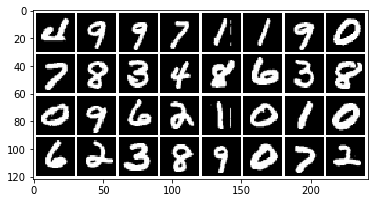

torch.Size([32, 1, 28, 28])


In [4]:
### LOAD DATA ###

dataset = 'mnist'
dataloader, imsize = data.load(dataset, path='/home/shared/phase-retrieval/data/' + dataset, batch_size=32)

sample = next(iter(dataloader['val']))
plot_grid(sample)
print(sample.shape)

In [200]:
# pytorch complex

def unpad(x, pad=14):
    return x[ ... , pad:3*pad, pad:3*pad]

def pad(x, pad=14):
    if type(x) == np.ndarray:
        raise np.pad(x, ((pad, pad), (pad, pad)))
    else:
        return F.pad(x, (pad, pad, pad, pad))

def cplx(x):
    return F.pad(x[... , None], (0, 1))

def calc_magn(x):
    ft =  torch.rfft(x, 2, onesided=False)
    magn = torch.sqrt(torch.sum(ft ** 2, -1) + 1e-16)
    return magn

def calc_circ_autocorr(x):
    return torch.irfft(cplx(calc_magn(x) ** 2), 2, onesided=False)
    
def calc_autocorr(x):
    return torch.irfft(cplx(calc_magn(pad(x)) ** 2), 2, onesided=False)

def fftshift(x):
    if type(x) == np.ndarray:
        return np.fft.fftshift(x, axes=(-1, -2))
    else:
        return np.fft.fftshift(x.numpy(), axes=(-1, -2))

def ifftshift(x):
    if type(x) == np.ndarray:
        return np.fft.ifftshift(x, axes=(-1, -2))
    else:
        return np.fft.ifftshift(x.numpy(), axes=(-1, -2))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


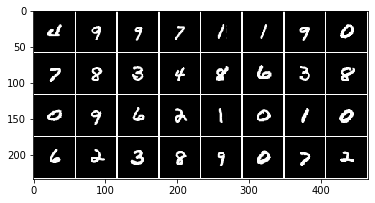

torch.Size([32, 1, 56, 56])


In [6]:
sample_pad = pad(sample)
plot_grid(sample_pad)
print(sample_pad.shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


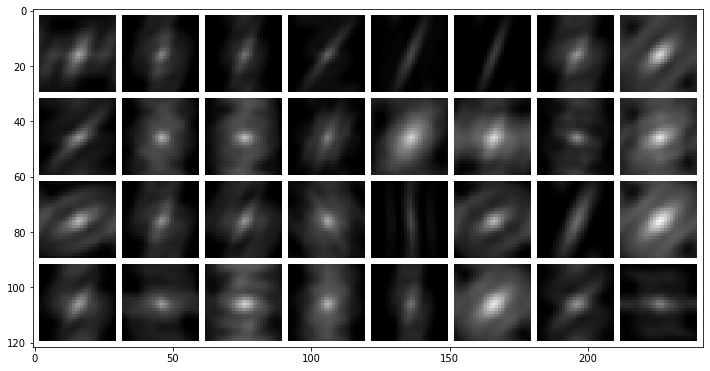

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Min: -7.6293945e-06 Max: 210.80988


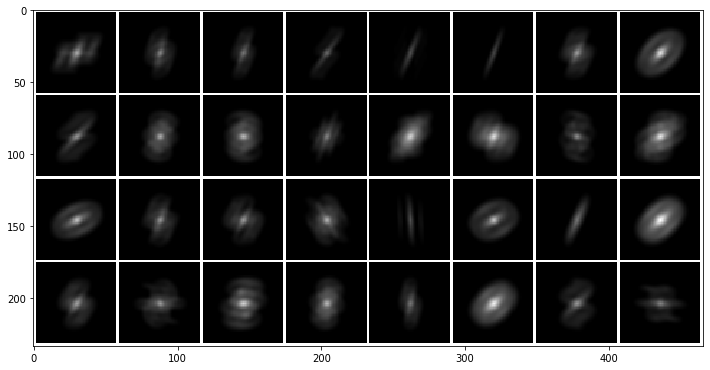

In [7]:
sample_circ_autocorr = fftshift(calc_circ_autocorr(sample))
plot_grid(sample_circ_autocorr / sample_circ_autocorr.max(), figsize=(12, 12))
print("Min:", sample_circ_autocorr.min(), "Max:", sample_circ_autocorr.max())

sample_autocorr = fftshift(calc_autocorr(sample))
plot_grid(sample_autocorr / sample_autocorr.max(), figsize=(12, 12))

Distribution of Autocorrelation function (without 0)


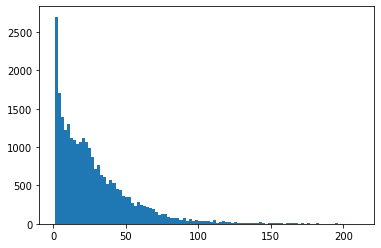

In [18]:
print("Distribution of Autocorrelation function (without 0)")
plt.hist(sample_autocorr.flatten(), bins=100, range=[1, sample_autocorr.max()])
plt.show()

Distribution of intensities


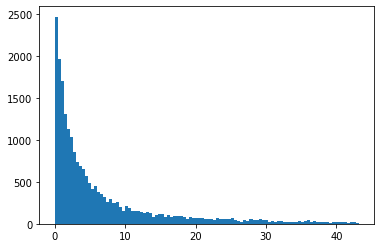

In [34]:
print("Distribution of intensities")
intens = (calc_magn(sample) ** 2).numpy()
plt.hist(intens.flatten(), bins=100, range=[0, 10 * np.median(intens)])
plt.show()

In [8]:
# Helper module to flatten vectors in nn.Sequential
class Flatten(nn.Module):
    
    def flatten(self, x):
        N = x.shape[0] # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image
    
    def forward(self, x):
        return self.flatten(x)


# Fully connected image network
class FCNet(nn.Module):

    __constants__ = ['mean', 'std']

    def __init__(self, imsize=(1, 28, 28), outsize=None, h=2048, mean=None, std=None):
        super(FCNet, self).__init__()
        print("Version 0.4")
        self.imsize = imsize
        if outsize is None:
            self.outsize = imsize
        else:
            self.outsize = outsize
        
        if mean is None:
            self.register_buffer('mean', torch.zeros(imsize))
        else:
            self.register_buffer('mean', torch.Tensor(mean))

        if std is None:
            self.register_buffer('std', torch.ones(imsize))
        else:
            self.register_buffer('std', torch.Tensor(std))
        
        self.layers = nn.Sequential(
            nn.Linear(imsize[0] * imsize[1] * imsize[2], h),
            nn.ReLU(),
            nn.Linear(h,h),
            nn.BatchNorm1d(h),
            nn.ReLU(),
            nn.Linear(h,h),
            nn.BatchNorm1d(h),
            nn.ReLU(),
            nn.Linear(h,h),
            nn.BatchNorm1d(h),
            nn.ReLU(),
            nn.Linear(h, self.outsize[0] * self.outsize[1] * self.outsize[2]),
        )
        
    def forward(self, x):
    
        N = x.shape[0]

        x_norm = (x - self.mean) / self.std
    
        out = self.layers(x_norm.view(N, -1))
        return torch.exp(out.view(N, *self.outsize))

In [9]:
def test_generator(model, device, testloader, one_batch=False):
    # put model to eval mode
    model = model.to(device=device)
    model.eval()

    # move test images to device and reduce to magnitude information in fourier space
    pred = []
    true = []
    
    for data in testloader:
        data = data.to(device=device)
        data_magn = calc_magn(data)
        
        true_autocorr = calc_autocorr(data)
        true_circ_autocorr = calc_circ_autocorr(data)
        
        pred_autocorr = model(true_circ_autocorr)

        true.append(true_autocorr.cpu().numpy())
        pred.append(pred_autocorr.cpu().detach().numpy())
        if one_batch: break
    
    return np.concatenate(pred), np.concatenate(true)

In [96]:
# Define loss

def loss_fn(pred, true):
    # Poisson likelihood
    return -torch.mean(torch.log(pred + 1) * (true + 1) - torch.lgamma(true + 1) - pred - 1)
    # Gaussian likelihood
    # return  torch.mean((pred - true) ** 2)

In [97]:
### Create new models ###

gen = FCNet(imsize=imsize, outsize=(1, 56, 56), h=2048)

Version 0.4


In [98]:
# Set training parameters

lr = 1e-3

history = []
opt = optim.Adam(gen.parameters(), lr=lr)

In [99]:
# Initial loss

gen = gen.to(device)

pred_autocorr = gen(calc_circ_autocorr(sample).to(device))

loss = loss_fn(pred=pred_autocorr, true=calc_autocorr(sample).to(device))

print("Generator loss:", loss.item())

Generator loss: 16.611242294311523


In [100]:
def train_model(gen, opt, device, loader_train, epochs=1):
    """
    Train a the conditional gan
    
    Returns: Loss history per iteration step
    """
    
    # move the model parameters to CPU/GPU
    gen = gen.to(device=device)
    
    # loss history
    history = []
    
    for e in range(epochs):
        
        print("Starting epoch {}".format(e+1))
        #with tqdm_notebook(total=len(loader_train.dataset)) as progress_bar:
        for t, (x) in enumerate(loader_train):
            # put model to training mode
            gen.train()

            # move x to device and reduce to magnitude information in fourier space
            x = x.to(device=device)
            autocorr = calc_autocorr(x)
            circ_autocorr = calc_circ_autocorr(x)

            # calculate loss and update generator
            loss = loss_fn(pred=gen(circ_autocorr), true=autocorr)
            opt.zero_grad()
            loss.backward()
            opt.step()

            history.append(loss.detach().cpu().item())

            #progress_bar.set_postfix(loss=np.mean(history[-100:]))
            #progress_bar.update(x.size(0))

            if t % 100 == 0:
                print("epoch: {:2} \t step:{} \t loss: {:3.4}".format(e + 1, t, history[-1]))  

        plt.plot(history[-20000:])
        plt.show()

        val_pred, val_true = test_generator(gen, device, dataloader['val'])
        to_plot = np.stack([val_true[:32, 0].reshape(4, 8, 56, 56),
                            val_pred[:32, 0].reshape(4, 8, 56, 56)], axis=1
                          ).reshape(-1, 1, 56, 56) 
        to_plot = fftshift(to_plot) / to_plot.max()
        plot_grid(to_plot, figsize=(10, 10))

        loss_val = np.mean((val_pred - val_true) ** 2)
        print("Mean squared dist:", loss_val)
            
    return history, loss_val

Starting epoch 1
epoch:  1 	 step:0 	 loss: 7.582
epoch:  1 	 step:100 	 loss: 1.227
epoch:  1 	 step:200 	 loss: 1.044
epoch:  1 	 step:300 	 loss: 1.047
epoch:  1 	 step:400 	 loss: 0.9653
epoch:  1 	 step:500 	 loss: 1.194
epoch:  1 	 step:600 	 loss: 1.208
epoch:  1 	 step:700 	 loss: 0.9513
epoch:  1 	 step:800 	 loss: 1.044
epoch:  1 	 step:900 	 loss: 0.9185
epoch:  1 	 step:1000 	 loss: 0.9033
epoch:  1 	 step:1100 	 loss: 0.9494
epoch:  1 	 step:1200 	 loss: 0.929
epoch:  1 	 step:1300 	 loss: 0.9774
epoch:  1 	 step:1400 	 loss: 0.9248
epoch:  1 	 step:1500 	 loss: 0.9031
epoch:  1 	 step:1600 	 loss: 0.9884
epoch:  1 	 step:1700 	 loss: 0.9634
epoch:  1 	 step:1800 	 loss: 0.8582


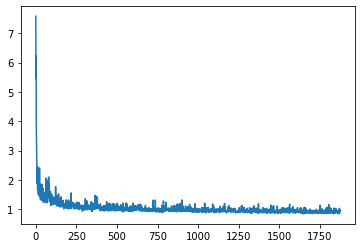

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


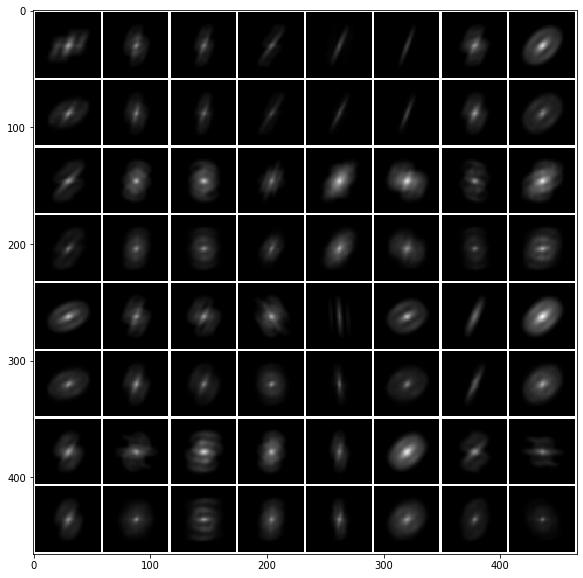

Mean squared dist: 14.393585
Starting epoch 2
epoch:  2 	 step:0 	 loss: 0.9822
epoch:  2 	 step:100 	 loss: 0.8753
epoch:  2 	 step:200 	 loss: 0.8571
epoch:  2 	 step:300 	 loss: 0.8952
epoch:  2 	 step:400 	 loss: 0.8435
epoch:  2 	 step:500 	 loss: 0.8621
epoch:  2 	 step:600 	 loss: 0.829
epoch:  2 	 step:700 	 loss: 0.9604
epoch:  2 	 step:800 	 loss: 0.8406
epoch:  2 	 step:900 	 loss: 0.8832
epoch:  2 	 step:1000 	 loss: 0.931
epoch:  2 	 step:1100 	 loss: 0.8935
epoch:  2 	 step:1200 	 loss: 0.8321
epoch:  2 	 step:1300 	 loss: 0.9227
epoch:  2 	 step:1400 	 loss: 0.8852
epoch:  2 	 step:1500 	 loss: 0.8343
epoch:  2 	 step:1600 	 loss: 0.8312
epoch:  2 	 step:1700 	 loss: 0.831
epoch:  2 	 step:1800 	 loss: 0.8578


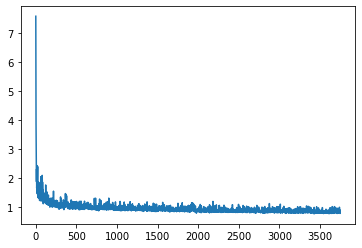

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


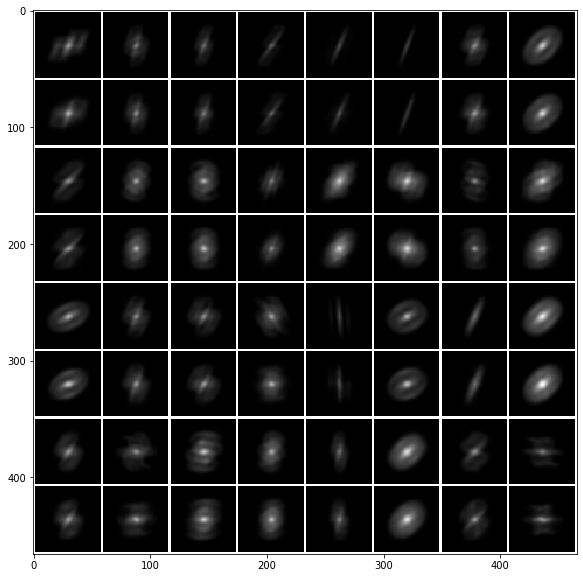

Mean squared dist: 5.261121
Starting epoch 3
epoch:  3 	 step:0 	 loss: 1.152
epoch:  3 	 step:100 	 loss: 0.8883
epoch:  3 	 step:200 	 loss: 0.8201
epoch:  3 	 step:300 	 loss: 0.8431
epoch:  3 	 step:400 	 loss: 0.811
epoch:  3 	 step:500 	 loss: 0.8078
epoch:  3 	 step:600 	 loss: 0.7995
epoch:  3 	 step:700 	 loss: 0.7995
epoch:  3 	 step:800 	 loss: 0.8046
epoch:  3 	 step:900 	 loss: 0.8843
epoch:  3 	 step:1000 	 loss: 0.8031
epoch:  3 	 step:1100 	 loss: 0.7791
epoch:  3 	 step:1200 	 loss: 0.7844
epoch:  3 	 step:1300 	 loss: 0.7874
epoch:  3 	 step:1400 	 loss: 0.7778
epoch:  3 	 step:1500 	 loss: 0.8116
epoch:  3 	 step:1600 	 loss: 0.7903
epoch:  3 	 step:1700 	 loss: 0.7771
epoch:  3 	 step:1800 	 loss: 0.803


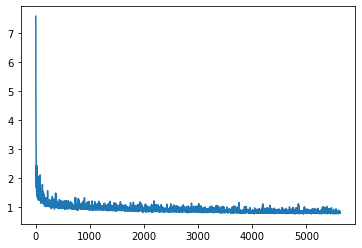

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


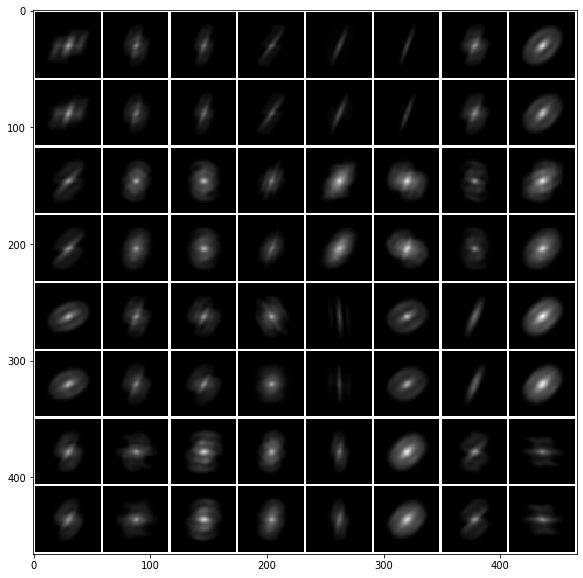

Mean squared dist: 2.1229403
Starting epoch 4
epoch:  4 	 step:0 	 loss: 0.79
epoch:  4 	 step:100 	 loss: 0.7883
epoch:  4 	 step:200 	 loss: 0.8011
epoch:  4 	 step:300 	 loss: 0.8216
epoch:  4 	 step:400 	 loss: 0.8058
epoch:  4 	 step:500 	 loss: 0.7695
epoch:  4 	 step:600 	 loss: 0.7931
epoch:  4 	 step:700 	 loss: 0.8234
epoch:  4 	 step:800 	 loss: 0.7892
epoch:  4 	 step:900 	 loss: 0.799
epoch:  4 	 step:1000 	 loss: 0.7464
epoch:  4 	 step:1100 	 loss: 0.7628
epoch:  4 	 step:1200 	 loss: 0.8592
epoch:  4 	 step:1300 	 loss: 0.8072
epoch:  4 	 step:1400 	 loss: 0.7949
epoch:  4 	 step:1500 	 loss: 0.8395
epoch:  4 	 step:1600 	 loss: 0.8411
epoch:  4 	 step:1700 	 loss: 0.8091
epoch:  4 	 step:1800 	 loss: 0.7478


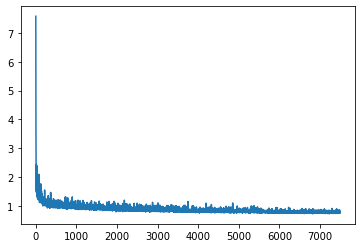

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


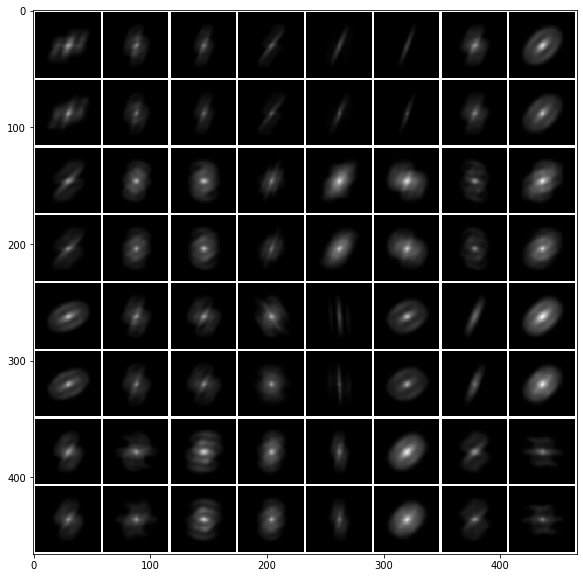

Mean squared dist: 3.0733173
Starting epoch 5
epoch:  5 	 step:0 	 loss: 0.8046
epoch:  5 	 step:100 	 loss: 0.8676
epoch:  5 	 step:200 	 loss: 0.7613
epoch:  5 	 step:300 	 loss: 0.7742
epoch:  5 	 step:400 	 loss: 0.8499
epoch:  5 	 step:500 	 loss: 0.7495
epoch:  5 	 step:600 	 loss: 0.7942
epoch:  5 	 step:700 	 loss: 0.848
epoch:  5 	 step:800 	 loss: 0.7785
epoch:  5 	 step:900 	 loss: 0.7483
epoch:  5 	 step:1000 	 loss: 0.7467
epoch:  5 	 step:1100 	 loss: 0.7647
epoch:  5 	 step:1200 	 loss: 0.7619
epoch:  5 	 step:1300 	 loss: 0.7431
epoch:  5 	 step:1400 	 loss: 0.775
epoch:  5 	 step:1500 	 loss: 0.8236
epoch:  5 	 step:1600 	 loss: 0.8098
epoch:  5 	 step:1700 	 loss: 0.7873
epoch:  5 	 step:1800 	 loss: 0.7494


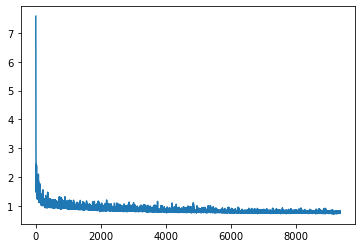

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


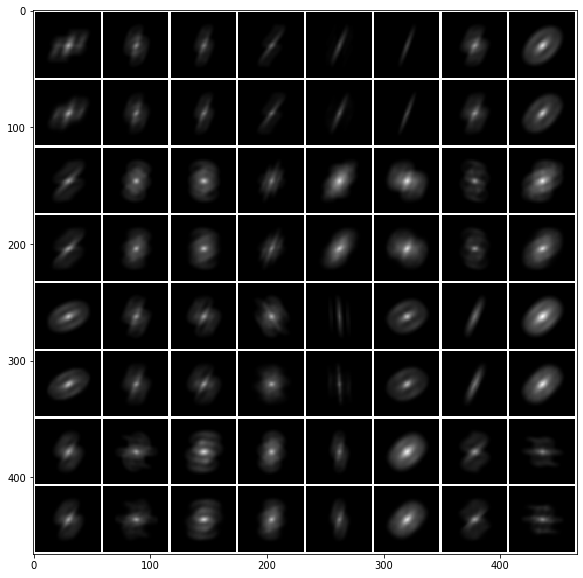

Mean squared dist: 1.7795242
Starting epoch 6
epoch:  6 	 step:0 	 loss: 0.763
epoch:  6 	 step:100 	 loss: 0.7505
epoch:  6 	 step:200 	 loss: 0.7598
epoch:  6 	 step:300 	 loss: 0.7736
epoch:  6 	 step:400 	 loss: 0.783
epoch:  6 	 step:500 	 loss: 0.7932
epoch:  6 	 step:600 	 loss: 0.7918
epoch:  6 	 step:700 	 loss: 0.8059
epoch:  6 	 step:800 	 loss: 0.7656
epoch:  6 	 step:900 	 loss: 0.7804
epoch:  6 	 step:1000 	 loss: 0.7498
epoch:  6 	 step:1100 	 loss: 0.7766
epoch:  6 	 step:1200 	 loss: 0.7394
epoch:  6 	 step:1300 	 loss: 0.7447
epoch:  6 	 step:1400 	 loss: 0.7524
epoch:  6 	 step:1500 	 loss: 0.7609
epoch:  6 	 step:1600 	 loss: 0.7789
epoch:  6 	 step:1700 	 loss: 0.7766
epoch:  6 	 step:1800 	 loss: 0.7868


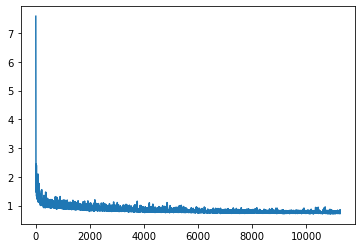

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


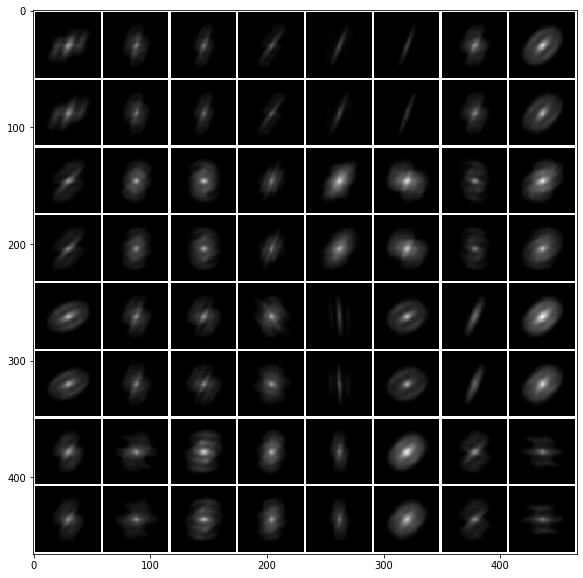

Mean squared dist: 2.5057442
Starting epoch 7
epoch:  7 	 step:0 	 loss: 0.7583
epoch:  7 	 step:100 	 loss: 0.7843
epoch:  7 	 step:200 	 loss: 0.7442
epoch:  7 	 step:300 	 loss: 0.8104
epoch:  7 	 step:400 	 loss: 0.793
epoch:  7 	 step:500 	 loss: 0.7531
epoch:  7 	 step:600 	 loss: 0.7668
epoch:  7 	 step:700 	 loss: 0.7502
epoch:  7 	 step:800 	 loss: 0.753
epoch:  7 	 step:900 	 loss: 0.7946
epoch:  7 	 step:1000 	 loss: 0.8014
epoch:  7 	 step:1100 	 loss: 0.7452
epoch:  7 	 step:1200 	 loss: 0.747
epoch:  7 	 step:1300 	 loss: 0.7816
epoch:  7 	 step:1400 	 loss: 0.7529
epoch:  7 	 step:1500 	 loss: 0.7288
epoch:  7 	 step:1600 	 loss: 0.7516
epoch:  7 	 step:1700 	 loss: 0.7526
epoch:  7 	 step:1800 	 loss: 0.7555


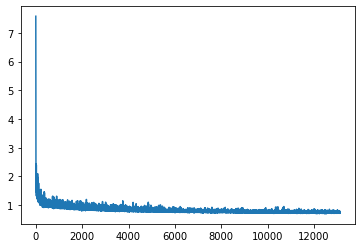

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


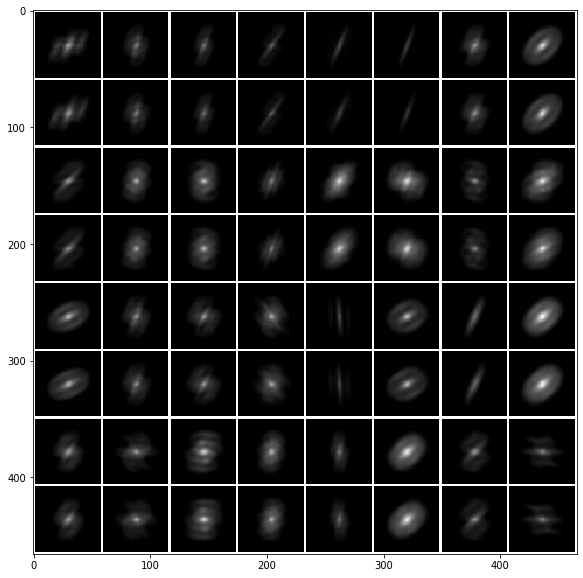

Mean squared dist: 1.0948006
Starting epoch 8
epoch:  8 	 step:0 	 loss: 0.754
epoch:  8 	 step:100 	 loss: 0.7402
epoch:  8 	 step:200 	 loss: 0.7264
epoch:  8 	 step:300 	 loss: 0.7355
epoch:  8 	 step:400 	 loss: 0.7122
epoch:  8 	 step:500 	 loss: 0.7986
epoch:  8 	 step:600 	 loss: 0.7638
epoch:  8 	 step:700 	 loss: 0.7647
epoch:  8 	 step:800 	 loss: 0.7602
epoch:  8 	 step:900 	 loss: 0.728
epoch:  8 	 step:1000 	 loss: 0.7333
epoch:  8 	 step:1100 	 loss: 0.7414
epoch:  8 	 step:1200 	 loss: 0.7774
epoch:  8 	 step:1300 	 loss: 0.7801
epoch:  8 	 step:1400 	 loss: 0.7419
epoch:  8 	 step:1500 	 loss: 0.7532
epoch:  8 	 step:1600 	 loss: 0.7514
epoch:  8 	 step:1700 	 loss: 0.7885
epoch:  8 	 step:1800 	 loss: 0.7656


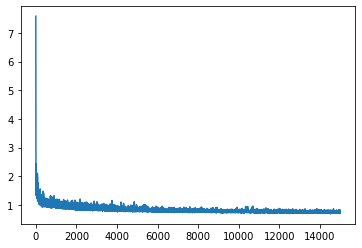

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


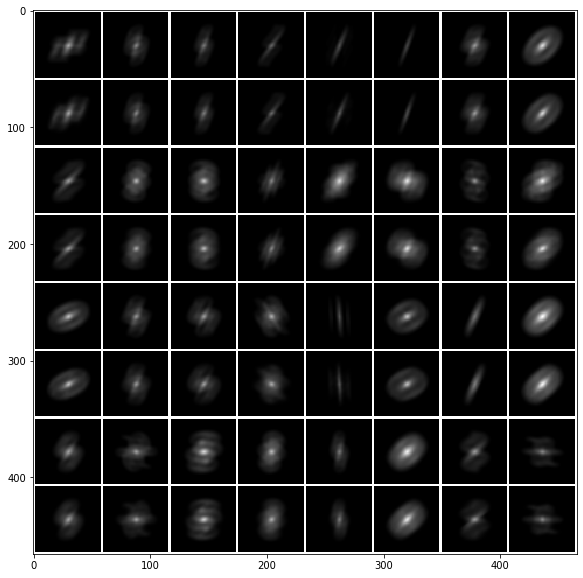

Mean squared dist: 1.2248205
Starting epoch 9
epoch:  9 	 step:0 	 loss: 0.7315
epoch:  9 	 step:100 	 loss: 0.7726
epoch:  9 	 step:200 	 loss: 0.7496
epoch:  9 	 step:300 	 loss: 0.7524
epoch:  9 	 step:400 	 loss: 0.782
epoch:  9 	 step:500 	 loss: 0.7863
epoch:  9 	 step:600 	 loss: 0.7328
epoch:  9 	 step:700 	 loss: 0.7275
epoch:  9 	 step:800 	 loss: 0.7348
epoch:  9 	 step:900 	 loss: 0.7599
epoch:  9 	 step:1000 	 loss: 0.7691
epoch:  9 	 step:1100 	 loss: 0.7635
epoch:  9 	 step:1200 	 loss: 0.7299
epoch:  9 	 step:1300 	 loss: 0.7205
epoch:  9 	 step:1400 	 loss: 0.7741
epoch:  9 	 step:1500 	 loss: 0.7361
epoch:  9 	 step:1600 	 loss: 0.7558
epoch:  9 	 step:1700 	 loss: 0.7315
epoch:  9 	 step:1800 	 loss: 0.7221


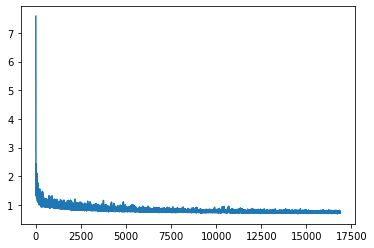

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


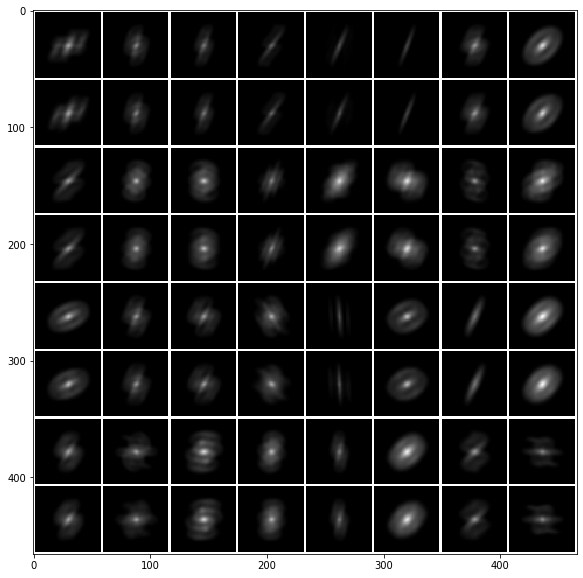

Mean squared dist: 0.9265828
Starting epoch 10
epoch: 10 	 step:0 	 loss: 0.7517
epoch: 10 	 step:100 	 loss: 0.7304
epoch: 10 	 step:200 	 loss: 0.7622
epoch: 10 	 step:300 	 loss: 0.7447
epoch: 10 	 step:400 	 loss: 0.7143
epoch: 10 	 step:500 	 loss: 0.7374
epoch: 10 	 step:600 	 loss: 0.7341
epoch: 10 	 step:700 	 loss: 0.7238
epoch: 10 	 step:800 	 loss: 0.7526
epoch: 10 	 step:900 	 loss: 0.6951
epoch: 10 	 step:1000 	 loss: 0.7561
epoch: 10 	 step:1100 	 loss: 0.7291
epoch: 10 	 step:1200 	 loss: 0.7429
epoch: 10 	 step:1300 	 loss: 0.7283
epoch: 10 	 step:1400 	 loss: 0.7383
epoch: 10 	 step:1500 	 loss: 0.7404
epoch: 10 	 step:1600 	 loss: 0.7304
epoch: 10 	 step:1700 	 loss: 0.7144
epoch: 10 	 step:1800 	 loss: 0.7359


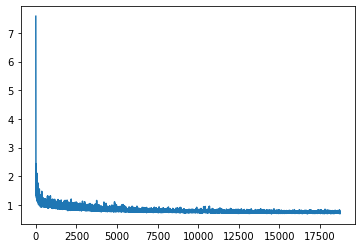

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


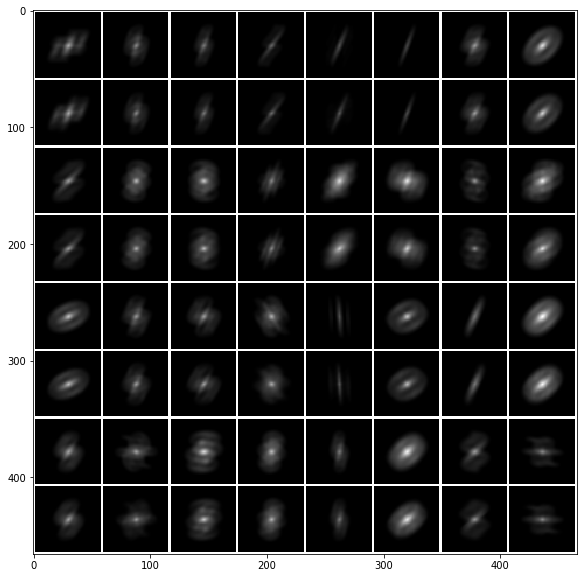

Mean squared dist: 1.5327249
Starting epoch 11
epoch: 11 	 step:0 	 loss: 0.7501
epoch: 11 	 step:100 	 loss: 0.7112
epoch: 11 	 step:200 	 loss: 0.7604
epoch: 11 	 step:300 	 loss: 0.7213
epoch: 11 	 step:400 	 loss: 0.7509
epoch: 11 	 step:500 	 loss: 0.7461
epoch: 11 	 step:600 	 loss: 0.7147
epoch: 11 	 step:700 	 loss: 0.7538
epoch: 11 	 step:800 	 loss: 0.7301
epoch: 11 	 step:900 	 loss: 0.7683
epoch: 11 	 step:1000 	 loss: 0.747
epoch: 11 	 step:1100 	 loss: 0.7367
epoch: 11 	 step:1200 	 loss: 0.8066
epoch: 11 	 step:1300 	 loss: 0.7433
epoch: 11 	 step:1400 	 loss: 0.7275
epoch: 11 	 step:1500 	 loss: 0.7091
epoch: 11 	 step:1600 	 loss: 0.735
epoch: 11 	 step:1700 	 loss: 0.7207
epoch: 11 	 step:1800 	 loss: 0.7338


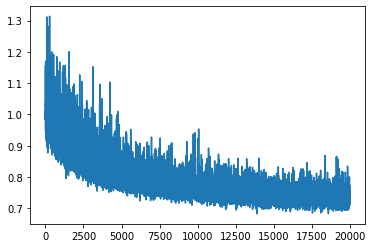

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


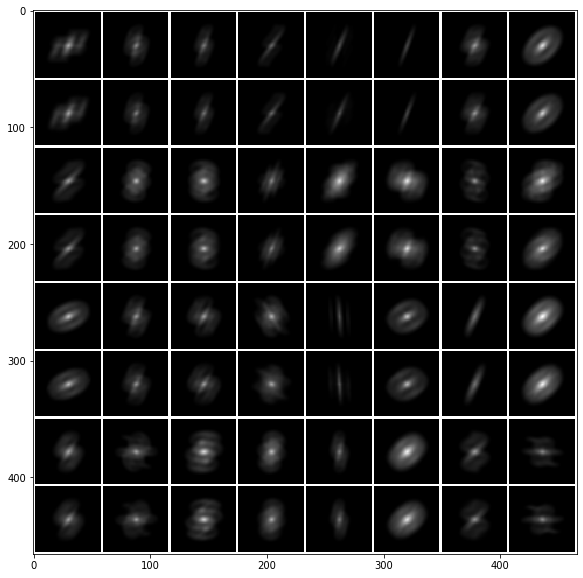

Mean squared dist: 1.2989253
Starting epoch 12
epoch: 12 	 step:0 	 loss: 0.7554
epoch: 12 	 step:100 	 loss: 0.7293
epoch: 12 	 step:200 	 loss: 0.7527
epoch: 12 	 step:300 	 loss: 0.725
epoch: 12 	 step:400 	 loss: 0.7497
epoch: 12 	 step:500 	 loss: 0.7357
epoch: 12 	 step:600 	 loss: 0.7216
epoch: 12 	 step:700 	 loss: 0.7509
epoch: 12 	 step:800 	 loss: 0.7472
epoch: 12 	 step:900 	 loss: 0.7298
epoch: 12 	 step:1000 	 loss: 0.7208
epoch: 12 	 step:1100 	 loss: 0.749
epoch: 12 	 step:1200 	 loss: 0.7392
epoch: 12 	 step:1300 	 loss: 0.7464
epoch: 12 	 step:1400 	 loss: 0.7933
epoch: 12 	 step:1500 	 loss: 0.7113
epoch: 12 	 step:1600 	 loss: 0.7672
epoch: 12 	 step:1700 	 loss: 0.7543
epoch: 12 	 step:1800 	 loss: 0.7302


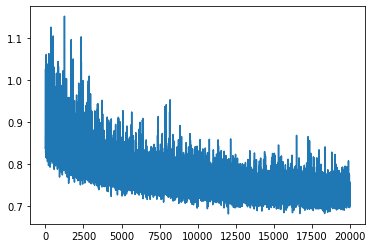

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


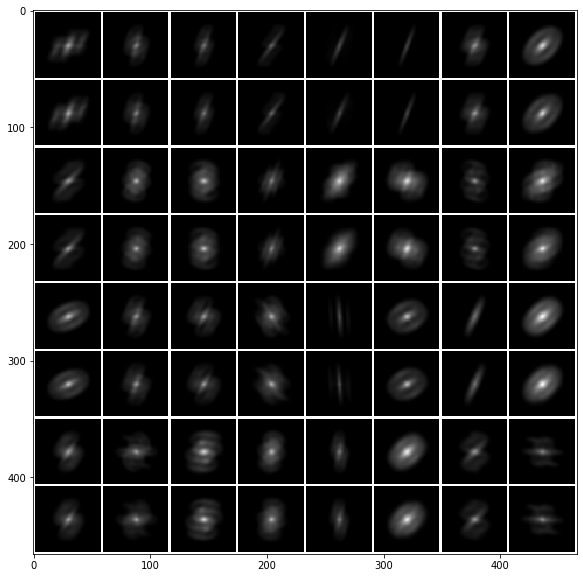

Mean squared dist: 0.9074324
Starting epoch 13
epoch: 13 	 step:0 	 loss: 0.735
epoch: 13 	 step:100 	 loss: 0.7579
epoch: 13 	 step:200 	 loss: 0.7461
epoch: 13 	 step:300 	 loss: 0.7564
epoch: 13 	 step:400 	 loss: 0.7367
epoch: 13 	 step:500 	 loss: 0.7604
epoch: 13 	 step:600 	 loss: 0.7191
epoch: 13 	 step:700 	 loss: 0.7223
epoch: 13 	 step:800 	 loss: 0.6979
epoch: 13 	 step:900 	 loss: 0.7533
epoch: 13 	 step:1000 	 loss: 0.7512
epoch: 13 	 step:1100 	 loss: 0.7366
epoch: 13 	 step:1200 	 loss: 0.7524
epoch: 13 	 step:1300 	 loss: 0.7336
epoch: 13 	 step:1400 	 loss: 0.7283
epoch: 13 	 step:1500 	 loss: 0.7679
epoch: 13 	 step:1600 	 loss: 0.7293
epoch: 13 	 step:1700 	 loss: 0.7096
epoch: 13 	 step:1800 	 loss: 0.7304


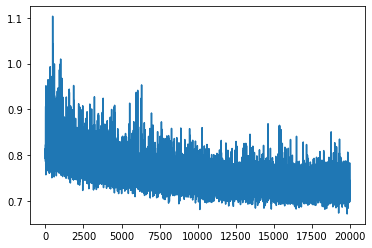

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


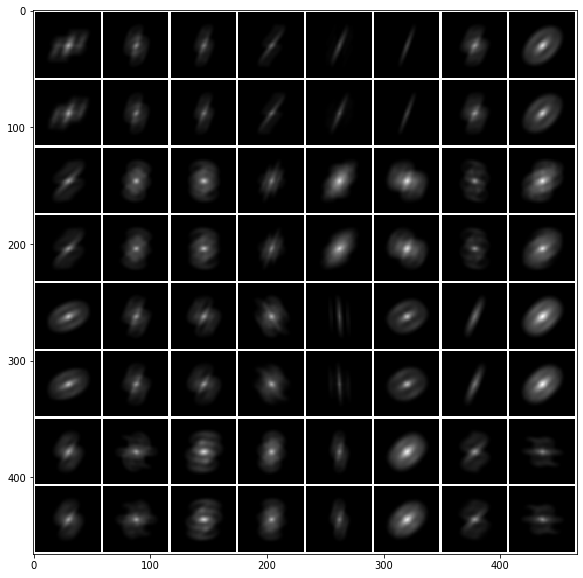

Mean squared dist: 0.97639495
Starting epoch 14
epoch: 14 	 step:0 	 loss: 0.7465
epoch: 14 	 step:100 	 loss: 0.6897
epoch: 14 	 step:200 	 loss: 0.7622
epoch: 14 	 step:300 	 loss: 0.7665
epoch: 14 	 step:400 	 loss: 0.7154
epoch: 14 	 step:500 	 loss: 0.7522
epoch: 14 	 step:600 	 loss: 0.7418
epoch: 14 	 step:700 	 loss: 0.7255
epoch: 14 	 step:800 	 loss: 0.7076
epoch: 14 	 step:900 	 loss: 0.7127
epoch: 14 	 step:1000 	 loss: 0.7441
epoch: 14 	 step:1100 	 loss: 0.7725
epoch: 14 	 step:1200 	 loss: 0.7397
epoch: 14 	 step:1300 	 loss: 0.7281
epoch: 14 	 step:1400 	 loss: 0.7367
epoch: 14 	 step:1500 	 loss: 0.7186
epoch: 14 	 step:1600 	 loss: 0.7166
epoch: 14 	 step:1700 	 loss: 0.7501
epoch: 14 	 step:1800 	 loss: 0.7597


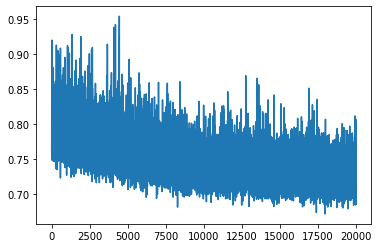

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


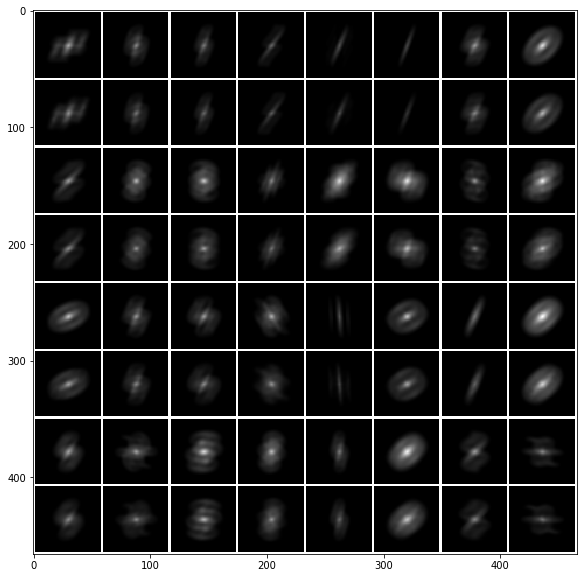

Mean squared dist: 3.4562893
Starting epoch 15
epoch: 15 	 step:0 	 loss: 0.7454
epoch: 15 	 step:100 	 loss: 0.755
epoch: 15 	 step:200 	 loss: 0.7209
epoch: 15 	 step:300 	 loss: 0.7599
epoch: 15 	 step:400 	 loss: 0.7512
epoch: 15 	 step:500 	 loss: 0.7518
epoch: 15 	 step:600 	 loss: 0.7403
epoch: 15 	 step:700 	 loss: 0.738
epoch: 15 	 step:800 	 loss: 0.7388
epoch: 15 	 step:900 	 loss: 0.7516
epoch: 15 	 step:1000 	 loss: 0.7395
epoch: 15 	 step:1100 	 loss: 0.7404
epoch: 15 	 step:1200 	 loss: 0.7164
epoch: 15 	 step:1300 	 loss: 0.722
epoch: 15 	 step:1400 	 loss: 0.7444
epoch: 15 	 step:1500 	 loss: 0.7123
epoch: 15 	 step:1600 	 loss: 0.7092
epoch: 15 	 step:1700 	 loss: 0.7195
epoch: 15 	 step:1800 	 loss: 0.7776


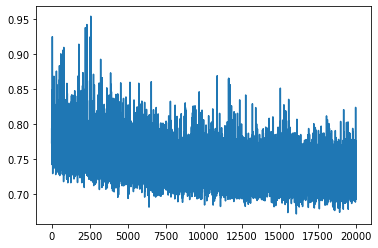

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


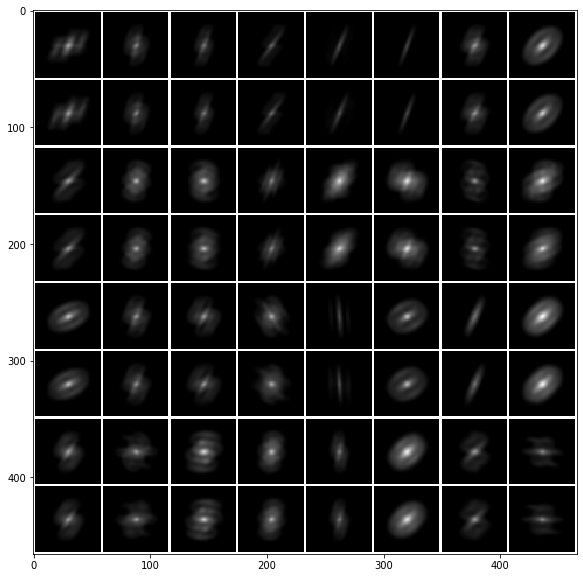

Mean squared dist: 0.955218
Starting epoch 16
epoch: 16 	 step:0 	 loss: 0.7245
epoch: 16 	 step:100 	 loss: 0.7136
epoch: 16 	 step:200 	 loss: 0.731
epoch: 16 	 step:300 	 loss: 0.7364
epoch: 16 	 step:400 	 loss: 0.7444
epoch: 16 	 step:500 	 loss: 0.689
epoch: 16 	 step:600 	 loss: 0.7472
epoch: 16 	 step:700 	 loss: 0.7209
epoch: 16 	 step:800 	 loss: 0.7527
epoch: 16 	 step:900 	 loss: 0.7055
epoch: 16 	 step:1000 	 loss: 0.7373
epoch: 16 	 step:1100 	 loss: 0.75
epoch: 16 	 step:1200 	 loss: 0.7468
epoch: 16 	 step:1300 	 loss: 0.6993
epoch: 16 	 step:1400 	 loss: 0.7369
epoch: 16 	 step:1500 	 loss: 0.7525
epoch: 16 	 step:1600 	 loss: 0.7504
epoch: 16 	 step:1700 	 loss: 0.7329
epoch: 16 	 step:1800 	 loss: 0.7391


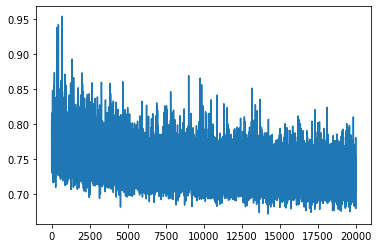

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


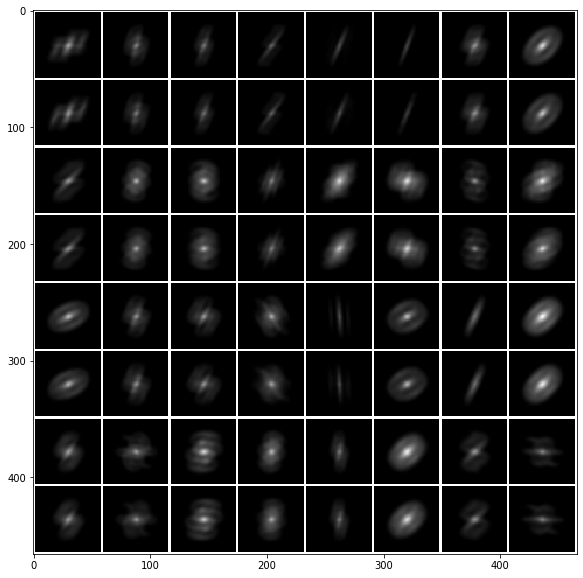

Mean squared dist: 1.1914239
Starting epoch 17
epoch: 17 	 step:0 	 loss: 0.7385
epoch: 17 	 step:100 	 loss: 0.7034
epoch: 17 	 step:200 	 loss: 0.7462
epoch: 17 	 step:300 	 loss: 0.7403
epoch: 17 	 step:400 	 loss: 0.7469
epoch: 17 	 step:500 	 loss: 0.7245
epoch: 17 	 step:600 	 loss: 0.7166
epoch: 17 	 step:700 	 loss: 0.7644
epoch: 17 	 step:800 	 loss: 0.6752
epoch: 17 	 step:900 	 loss: 0.7234
epoch: 17 	 step:1000 	 loss: 0.7252
epoch: 17 	 step:1100 	 loss: 0.7164
epoch: 17 	 step:1200 	 loss: 0.7443
epoch: 17 	 step:1300 	 loss: 0.7246
epoch: 17 	 step:1400 	 loss: 0.7145
epoch: 17 	 step:1500 	 loss: 0.738
epoch: 17 	 step:1600 	 loss: 0.7407
epoch: 17 	 step:1700 	 loss: 0.7149
epoch: 17 	 step:1800 	 loss: 0.7402


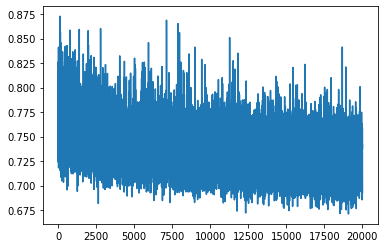

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


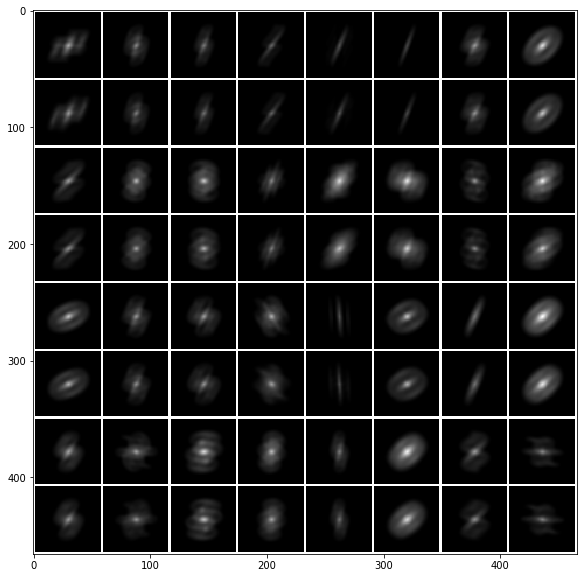

Mean squared dist: 2.0925326
Starting epoch 18
epoch: 18 	 step:0 	 loss: 0.7314
epoch: 18 	 step:100 	 loss: 0.6991
epoch: 18 	 step:200 	 loss: 0.7361
epoch: 18 	 step:300 	 loss: 0.7254
epoch: 18 	 step:400 	 loss: 0.733
epoch: 18 	 step:500 	 loss: 0.7289
epoch: 18 	 step:600 	 loss: 0.7032
epoch: 18 	 step:700 	 loss: 0.6887
epoch: 18 	 step:800 	 loss: 0.7186
epoch: 18 	 step:900 	 loss: 0.7059
epoch: 18 	 step:1000 	 loss: 0.7187
epoch: 18 	 step:1100 	 loss: 0.7338
epoch: 18 	 step:1200 	 loss: 0.737
epoch: 18 	 step:1300 	 loss: 0.7784
epoch: 18 	 step:1400 	 loss: 0.7533
epoch: 18 	 step:1500 	 loss: 0.703
epoch: 18 	 step:1600 	 loss: 0.6901
epoch: 18 	 step:1700 	 loss: 0.7253
epoch: 18 	 step:1800 	 loss: 0.7199


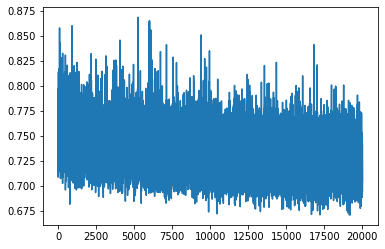

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


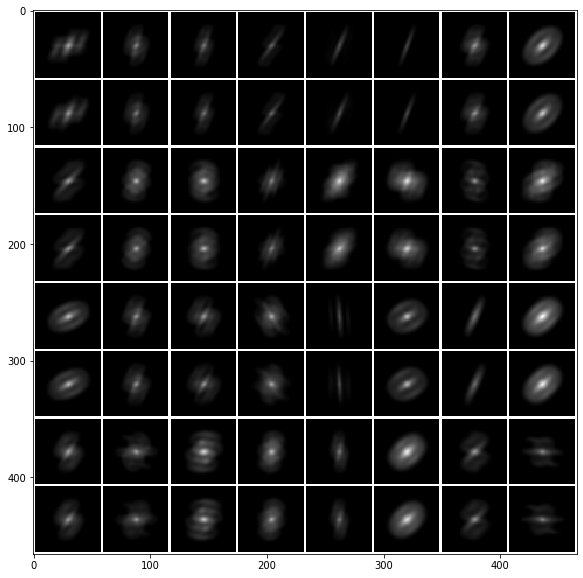

Mean squared dist: 1.17843
Starting epoch 19
epoch: 19 	 step:0 	 loss: 0.7361
epoch: 19 	 step:100 	 loss: 0.7003
epoch: 19 	 step:200 	 loss: 0.702
epoch: 19 	 step:300 	 loss: 0.7428
epoch: 19 	 step:400 	 loss: 0.7179
epoch: 19 	 step:500 	 loss: 0.7021
epoch: 19 	 step:600 	 loss: 0.7416
epoch: 19 	 step:700 	 loss: 0.7031
epoch: 19 	 step:800 	 loss: 0.765
epoch: 19 	 step:900 	 loss: 0.7347
epoch: 19 	 step:1000 	 loss: 0.7588
epoch: 19 	 step:1100 	 loss: 0.7136
epoch: 19 	 step:1200 	 loss: 0.7267
epoch: 19 	 step:1300 	 loss: 0.7269
epoch: 19 	 step:1400 	 loss: 0.7326
epoch: 19 	 step:1500 	 loss: 0.693
epoch: 19 	 step:1600 	 loss: 0.6963
epoch: 19 	 step:1700 	 loss: 0.7275
epoch: 19 	 step:1800 	 loss: 0.7302


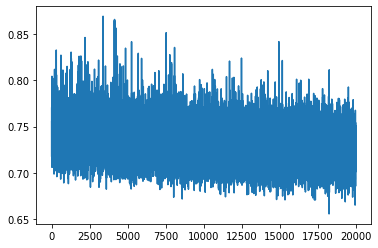

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


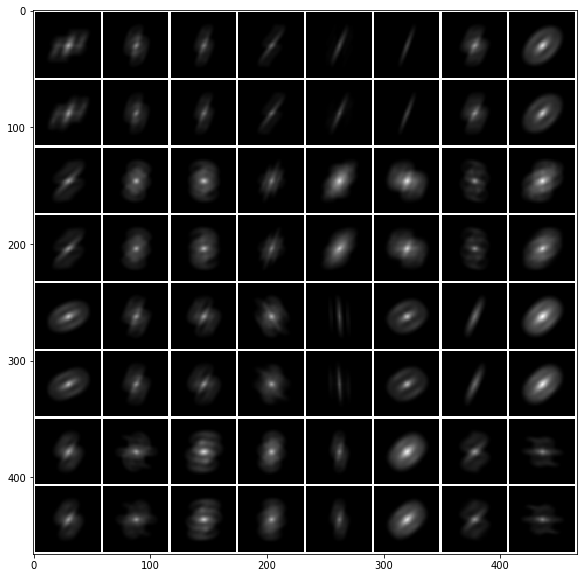

Mean squared dist: 1.2358042
Starting epoch 20
epoch: 20 	 step:0 	 loss: 0.7515
epoch: 20 	 step:100 	 loss: 0.7342
epoch: 20 	 step:200 	 loss: 0.7228
epoch: 20 	 step:300 	 loss: 0.696
epoch: 20 	 step:400 	 loss: 0.7393
epoch: 20 	 step:500 	 loss: 0.6951
epoch: 20 	 step:600 	 loss: 0.6914
epoch: 20 	 step:700 	 loss: 0.7134
epoch: 20 	 step:800 	 loss: 0.7713
epoch: 20 	 step:900 	 loss: 0.6914
epoch: 20 	 step:1000 	 loss: 0.7061
epoch: 20 	 step:1100 	 loss: 0.748
epoch: 20 	 step:1200 	 loss: 0.7424
epoch: 20 	 step:1300 	 loss: 0.6994
epoch: 20 	 step:1400 	 loss: 0.7406
epoch: 20 	 step:1500 	 loss: 0.7393
epoch: 20 	 step:1600 	 loss: 0.7126
epoch: 20 	 step:1700 	 loss: 0.7426
epoch: 20 	 step:1800 	 loss: 0.753


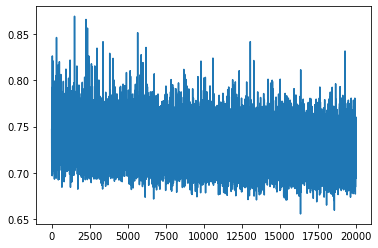

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


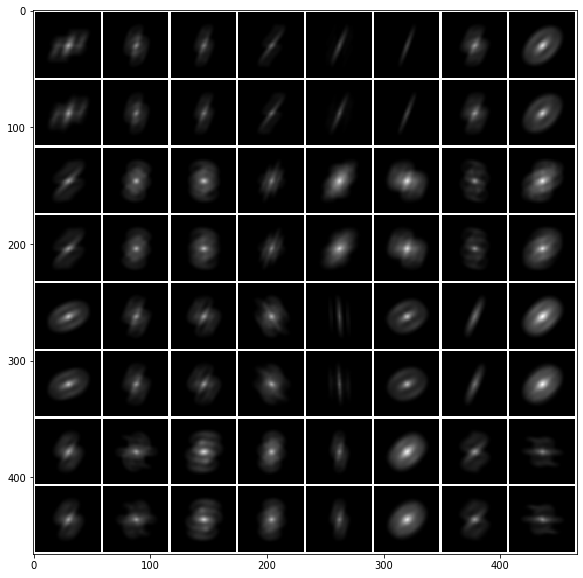

Mean squared dist: 0.8900396
Starting epoch 21
epoch: 21 	 step:0 	 loss: 0.7071
epoch: 21 	 step:100 	 loss: 0.7236
epoch: 21 	 step:200 	 loss: 0.7745
epoch: 21 	 step:300 	 loss: 0.722
epoch: 21 	 step:400 	 loss: 0.7682
epoch: 21 	 step:500 	 loss: 0.7529
epoch: 21 	 step:600 	 loss: 0.7358
epoch: 21 	 step:700 	 loss: 0.7047
epoch: 21 	 step:800 	 loss: 0.7292
epoch: 21 	 step:900 	 loss: 0.7404
epoch: 21 	 step:1000 	 loss: 0.734
epoch: 21 	 step:1100 	 loss: 0.7156
epoch: 21 	 step:1200 	 loss: 0.7501
epoch: 21 	 step:1300 	 loss: 0.7067
epoch: 21 	 step:1400 	 loss: 0.718
epoch: 21 	 step:1500 	 loss: 0.7334
epoch: 21 	 step:1600 	 loss: 0.7137
epoch: 21 	 step:1700 	 loss: 0.6959
epoch: 21 	 step:1800 	 loss: 0.7494


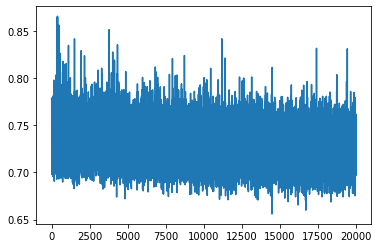

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


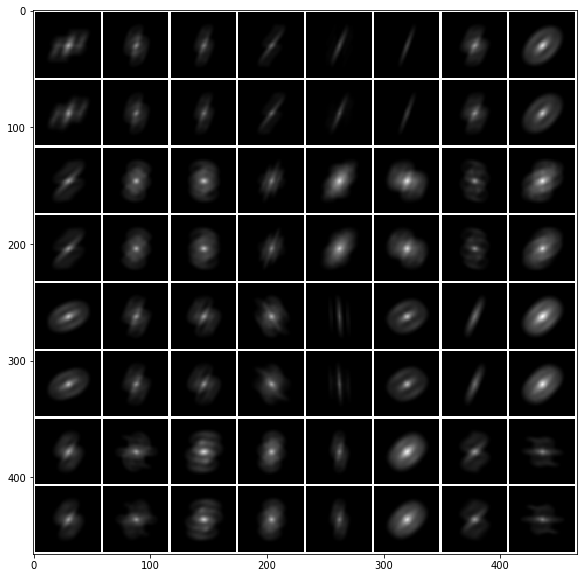

Mean squared dist: 1.2569734
Starting epoch 22
epoch: 22 	 step:0 	 loss: 0.7286
epoch: 22 	 step:100 	 loss: 0.7514
epoch: 22 	 step:200 	 loss: 0.6985
epoch: 22 	 step:300 	 loss: 0.7138
epoch: 22 	 step:400 	 loss: 0.7215
epoch: 22 	 step:500 	 loss: 0.6895
epoch: 22 	 step:600 	 loss: 0.7553
epoch: 22 	 step:700 	 loss: 0.7248
epoch: 22 	 step:800 	 loss: 0.7211
epoch: 22 	 step:900 	 loss: 0.7422
epoch: 22 	 step:1000 	 loss: 0.7028
epoch: 22 	 step:1100 	 loss: 0.7079
epoch: 22 	 step:1200 	 loss: 0.7393
epoch: 22 	 step:1300 	 loss: 0.7157
epoch: 22 	 step:1400 	 loss: 0.7711
epoch: 22 	 step:1500 	 loss: 0.7306
epoch: 22 	 step:1600 	 loss: 0.7037
epoch: 22 	 step:1700 	 loss: 0.7414
epoch: 22 	 step:1800 	 loss: 0.7444


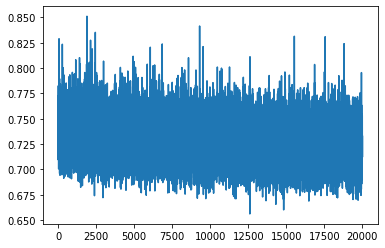

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


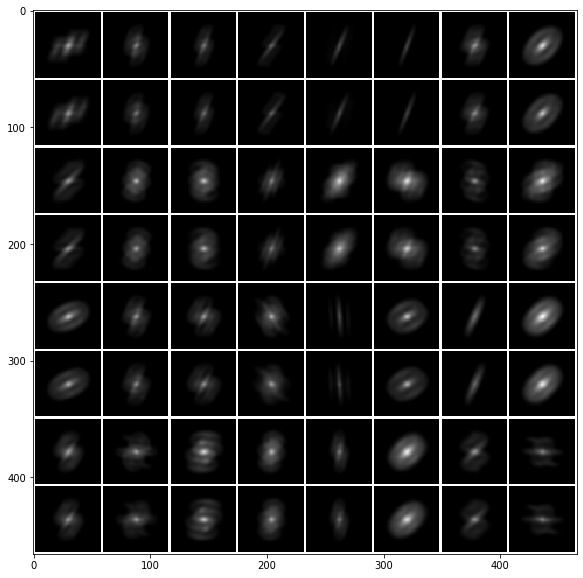

Mean squared dist: 1.6129936
Starting epoch 23
epoch: 23 	 step:0 	 loss: 0.7297
epoch: 23 	 step:100 	 loss: 0.7096
epoch: 23 	 step:200 	 loss: 0.7454
epoch: 23 	 step:300 	 loss: 0.7103
epoch: 23 	 step:400 	 loss: 0.6999
epoch: 23 	 step:500 	 loss: 0.7101
epoch: 23 	 step:600 	 loss: 0.6938
epoch: 23 	 step:700 	 loss: 0.7284
epoch: 23 	 step:800 	 loss: 0.7355
epoch: 23 	 step:900 	 loss: 0.7451
epoch: 23 	 step:1000 	 loss: 0.7069
epoch: 23 	 step:1100 	 loss: 0.7105
epoch: 23 	 step:1200 	 loss: 0.7125
epoch: 23 	 step:1300 	 loss: 0.7375
epoch: 23 	 step:1400 	 loss: 0.7141
epoch: 23 	 step:1500 	 loss: 0.6915
epoch: 23 	 step:1600 	 loss: 0.7376
epoch: 23 	 step:1700 	 loss: 0.7296
epoch: 23 	 step:1800 	 loss: 0.7473


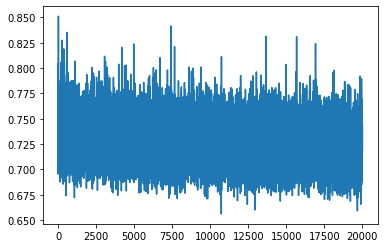

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


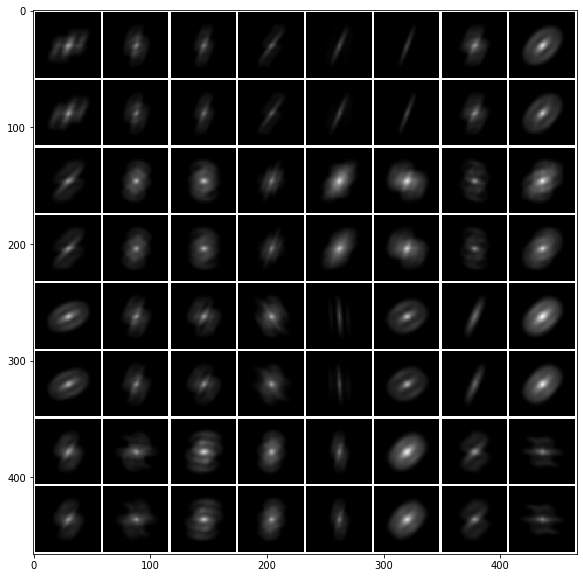

Mean squared dist: 1.6038831
Starting epoch 24
epoch: 24 	 step:0 	 loss: 0.7245
epoch: 24 	 step:100 	 loss: 0.7191
epoch: 24 	 step:200 	 loss: 0.6983
epoch: 24 	 step:300 	 loss: 0.7292
epoch: 24 	 step:400 	 loss: 0.6829
epoch: 24 	 step:500 	 loss: 0.7166
epoch: 24 	 step:600 	 loss: 0.7111
epoch: 24 	 step:700 	 loss: 0.6702
epoch: 24 	 step:800 	 loss: 0.7393
epoch: 24 	 step:900 	 loss: 0.7393
epoch: 24 	 step:1000 	 loss: 0.7142
epoch: 24 	 step:1100 	 loss: 0.7187
epoch: 24 	 step:1200 	 loss: 0.7106
epoch: 24 	 step:1300 	 loss: 0.7343
epoch: 24 	 step:1400 	 loss: 0.7298
epoch: 24 	 step:1500 	 loss: 0.7228
epoch: 24 	 step:1600 	 loss: 0.721
epoch: 24 	 step:1700 	 loss: 0.7043
epoch: 24 	 step:1800 	 loss: 0.6743


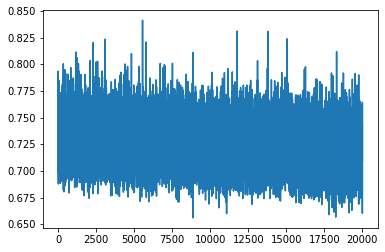

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


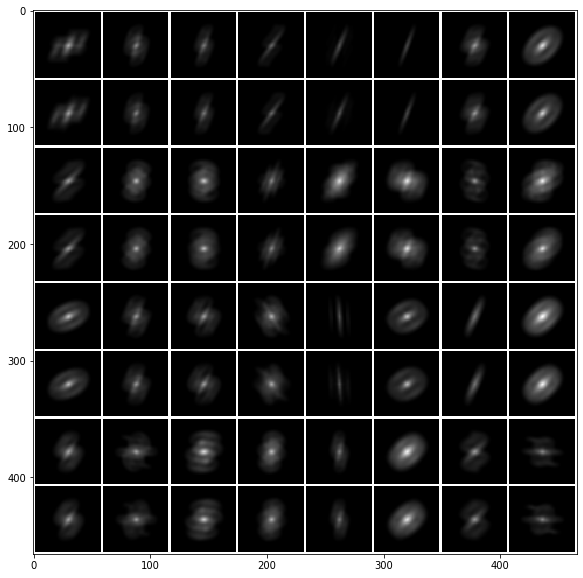

Mean squared dist: 0.92089635
Starting epoch 25
epoch: 25 	 step:0 	 loss: 0.6824
epoch: 25 	 step:100 	 loss: 0.7361
epoch: 25 	 step:200 	 loss: 0.7606
epoch: 25 	 step:300 	 loss: 0.6879
epoch: 25 	 step:400 	 loss: 0.7273
epoch: 25 	 step:500 	 loss: 0.7585
epoch: 25 	 step:600 	 loss: 0.7481
epoch: 25 	 step:700 	 loss: 0.7406
epoch: 25 	 step:800 	 loss: 0.6932
epoch: 25 	 step:900 	 loss: 0.6907
epoch: 25 	 step:1000 	 loss: 0.708
epoch: 25 	 step:1100 	 loss: 0.7493
epoch: 25 	 step:1200 	 loss: 0.7302
epoch: 25 	 step:1300 	 loss: 0.7278
epoch: 25 	 step:1400 	 loss: 0.7167
epoch: 25 	 step:1500 	 loss: 0.6815
epoch: 25 	 step:1600 	 loss: 0.7307
epoch: 25 	 step:1700 	 loss: 0.69
epoch: 25 	 step:1800 	 loss: 0.6887


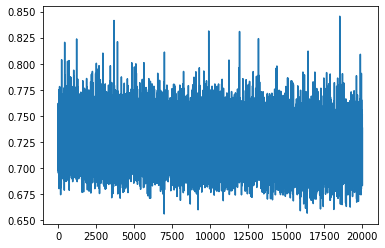

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


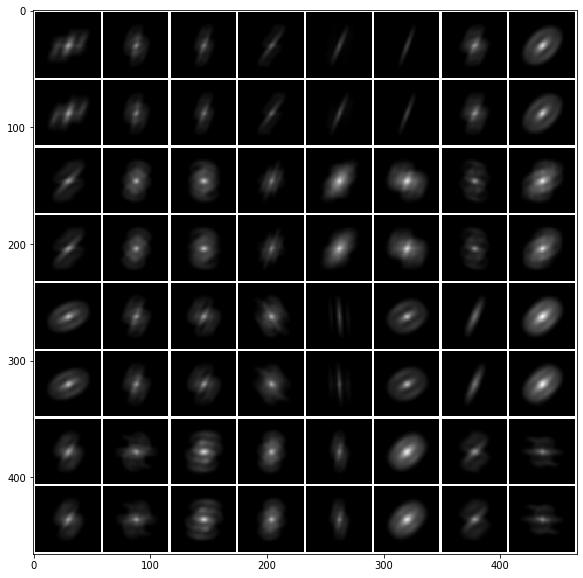

Mean squared dist: 0.63554883
Starting epoch 26
epoch: 26 	 step:0 	 loss: 0.6909
epoch: 26 	 step:100 	 loss: 0.709
epoch: 26 	 step:200 	 loss: 0.7104
epoch: 26 	 step:300 	 loss: 0.7423
epoch: 26 	 step:400 	 loss: 0.713
epoch: 26 	 step:500 	 loss: 0.7523
epoch: 26 	 step:600 	 loss: 0.7203
epoch: 26 	 step:700 	 loss: 0.7405
epoch: 26 	 step:800 	 loss: 0.7078
epoch: 26 	 step:900 	 loss: 0.7174
epoch: 26 	 step:1000 	 loss: 0.735
epoch: 26 	 step:1100 	 loss: 0.7325
epoch: 26 	 step:1200 	 loss: 0.7417
epoch: 26 	 step:1300 	 loss: 0.7103
epoch: 26 	 step:1400 	 loss: 0.7253
epoch: 26 	 step:1500 	 loss: 0.7219
epoch: 26 	 step:1600 	 loss: 0.6872
epoch: 26 	 step:1700 	 loss: 0.7355
epoch: 26 	 step:1800 	 loss: 0.7109


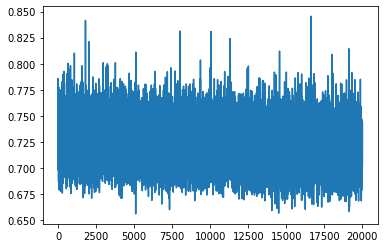

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


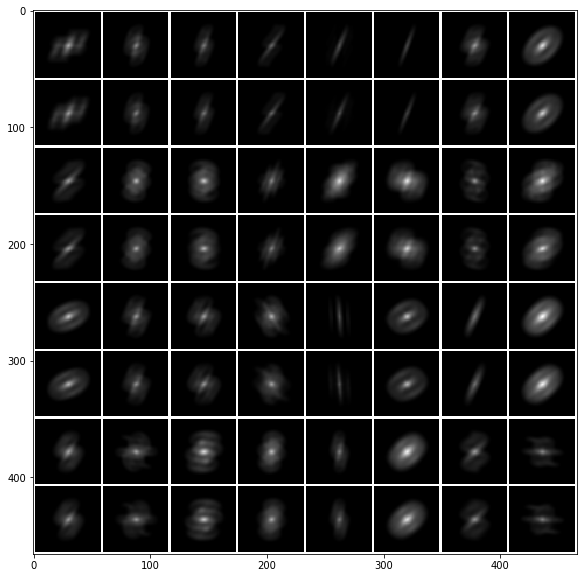

Mean squared dist: 1.1716394
Starting epoch 27
epoch: 27 	 step:0 	 loss: 0.698
epoch: 27 	 step:100 	 loss: 0.7057
epoch: 27 	 step:200 	 loss: 0.7048
epoch: 27 	 step:300 	 loss: 0.7236
epoch: 27 	 step:400 	 loss: 0.7001
epoch: 27 	 step:500 	 loss: 0.7419
epoch: 27 	 step:600 	 loss: 0.7162
epoch: 27 	 step:700 	 loss: 0.7068
epoch: 27 	 step:800 	 loss: 0.7234
epoch: 27 	 step:900 	 loss: 0.7158
epoch: 27 	 step:1000 	 loss: 0.7169
epoch: 27 	 step:1100 	 loss: 0.7038
epoch: 27 	 step:1200 	 loss: 0.726
epoch: 27 	 step:1300 	 loss: 0.7323
epoch: 27 	 step:1400 	 loss: 0.7139
epoch: 27 	 step:1500 	 loss: 0.7018
epoch: 27 	 step:1600 	 loss: 0.7571
epoch: 27 	 step:1700 	 loss: 0.7109
epoch: 27 	 step:1800 	 loss: 0.7002


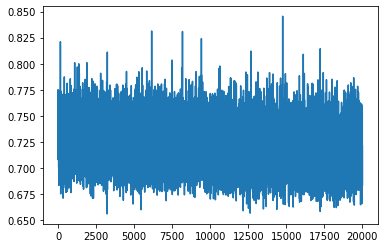

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


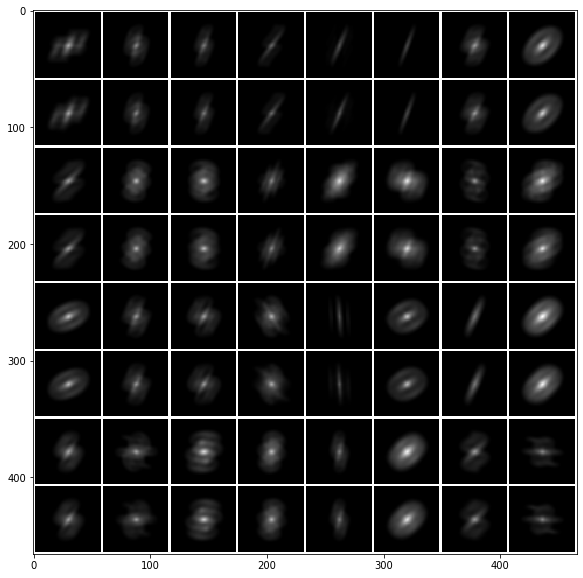

Mean squared dist: 0.8640265
Starting epoch 28
epoch: 28 	 step:0 	 loss: 0.7623
epoch: 28 	 step:100 	 loss: 0.7017
epoch: 28 	 step:200 	 loss: 0.7209
epoch: 28 	 step:300 	 loss: 0.7137
epoch: 28 	 step:400 	 loss: 0.7142
epoch: 28 	 step:500 	 loss: 0.7942
epoch: 28 	 step:600 	 loss: 0.717
epoch: 28 	 step:700 	 loss: 0.701
epoch: 28 	 step:800 	 loss: 0.7335
epoch: 28 	 step:900 	 loss: 0.7576
epoch: 28 	 step:1000 	 loss: 0.7409
epoch: 28 	 step:1100 	 loss: 0.7352
epoch: 28 	 step:1200 	 loss: 0.7398
epoch: 28 	 step:1300 	 loss: 0.6981
epoch: 28 	 step:1400 	 loss: 0.6942
epoch: 28 	 step:1500 	 loss: 0.7213
epoch: 28 	 step:1600 	 loss: 0.7373
epoch: 28 	 step:1700 	 loss: 0.7107
epoch: 28 	 step:1800 	 loss: 0.7196


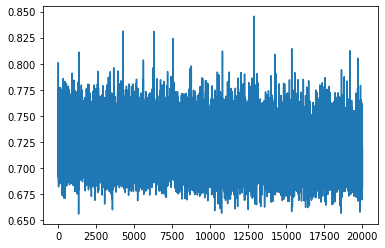

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


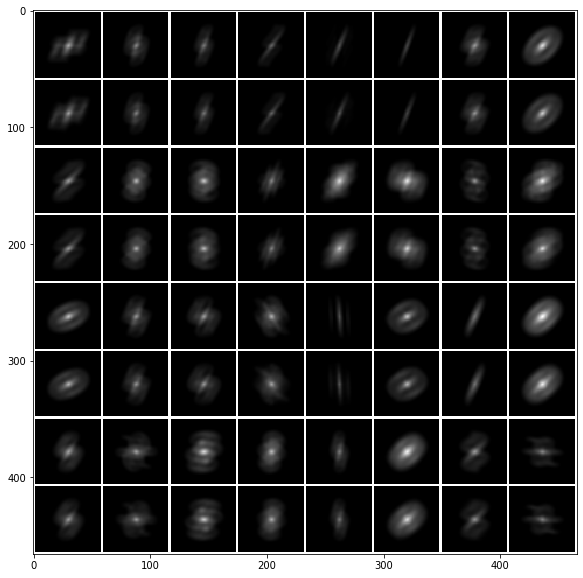

Mean squared dist: 1.1958475
Starting epoch 29
epoch: 29 	 step:0 	 loss: 0.7446
epoch: 29 	 step:100 	 loss: 0.6954
epoch: 29 	 step:200 	 loss: 0.7008
epoch: 29 	 step:300 	 loss: 0.6807
epoch: 29 	 step:400 	 loss: 0.7057
epoch: 29 	 step:500 	 loss: 0.7384
epoch: 29 	 step:600 	 loss: 0.7177
epoch: 29 	 step:700 	 loss: 0.7063
epoch: 29 	 step:800 	 loss: 0.7492
epoch: 29 	 step:900 	 loss: 0.705
epoch: 29 	 step:1000 	 loss: 0.7255
epoch: 29 	 step:1100 	 loss: 0.6934
epoch: 29 	 step:1200 	 loss: 0.7061
epoch: 29 	 step:1300 	 loss: 0.7172
epoch: 29 	 step:1400 	 loss: 0.7042
epoch: 29 	 step:1500 	 loss: 0.7194
epoch: 29 	 step:1600 	 loss: 0.699
epoch: 29 	 step:1700 	 loss: 0.708
epoch: 29 	 step:1800 	 loss: 0.7458


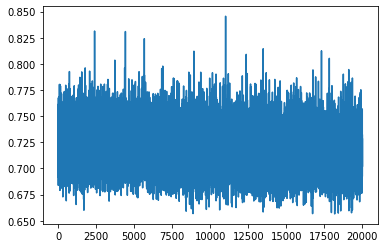

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


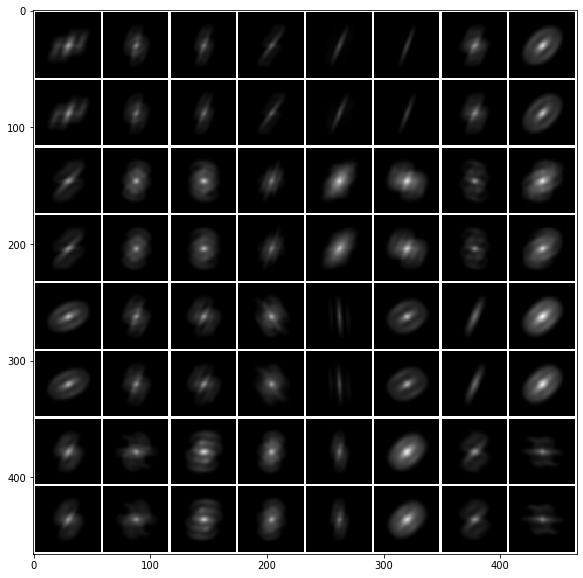

Mean squared dist: 1.0755614
Starting epoch 30
epoch: 30 	 step:0 	 loss: 0.7164
epoch: 30 	 step:100 	 loss: 0.7125
epoch: 30 	 step:200 	 loss: 0.7022
epoch: 30 	 step:300 	 loss: 0.7358
epoch: 30 	 step:400 	 loss: 0.6987
epoch: 30 	 step:500 	 loss: 0.6968
epoch: 30 	 step:600 	 loss: 0.6984
epoch: 30 	 step:700 	 loss: 0.7349
epoch: 30 	 step:800 	 loss: 0.7122
epoch: 30 	 step:900 	 loss: 0.7158
epoch: 30 	 step:1000 	 loss: 0.6847
epoch: 30 	 step:1100 	 loss: 0.7288
epoch: 30 	 step:1200 	 loss: 0.7242
epoch: 30 	 step:1300 	 loss: 0.7125
epoch: 30 	 step:1400 	 loss: 0.7152
epoch: 30 	 step:1500 	 loss: 0.7363
epoch: 30 	 step:1600 	 loss: 0.7355
epoch: 30 	 step:1700 	 loss: 0.7043
epoch: 30 	 step:1800 	 loss: 0.7269


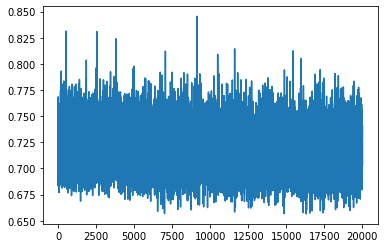

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


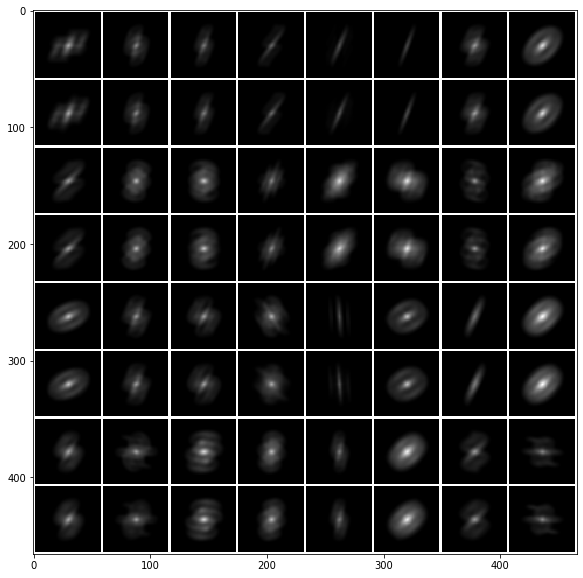

Mean squared dist: 0.5910185
Starting epoch 31
epoch: 31 	 step:0 	 loss: 0.6955
epoch: 31 	 step:100 	 loss: 0.7549
epoch: 31 	 step:200 	 loss: 0.6997
epoch: 31 	 step:300 	 loss: 0.7077
epoch: 31 	 step:400 	 loss: 0.7306
epoch: 31 	 step:500 	 loss: 0.6958
epoch: 31 	 step:600 	 loss: 0.731
epoch: 31 	 step:700 	 loss: 0.7038
epoch: 31 	 step:800 	 loss: 0.7357
epoch: 31 	 step:900 	 loss: 0.7042
epoch: 31 	 step:1000 	 loss: 0.7381
epoch: 31 	 step:1100 	 loss: 0.7098
epoch: 31 	 step:1200 	 loss: 0.7091
epoch: 31 	 step:1300 	 loss: 0.7199
epoch: 31 	 step:1400 	 loss: 0.7283
epoch: 31 	 step:1500 	 loss: 0.7126
epoch: 31 	 step:1600 	 loss: 0.6821
epoch: 31 	 step:1700 	 loss: 0.737
epoch: 31 	 step:1800 	 loss: 0.7261


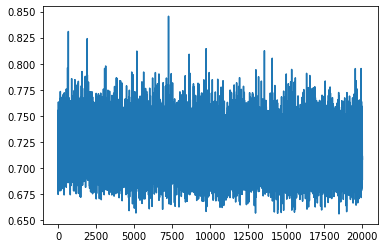

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


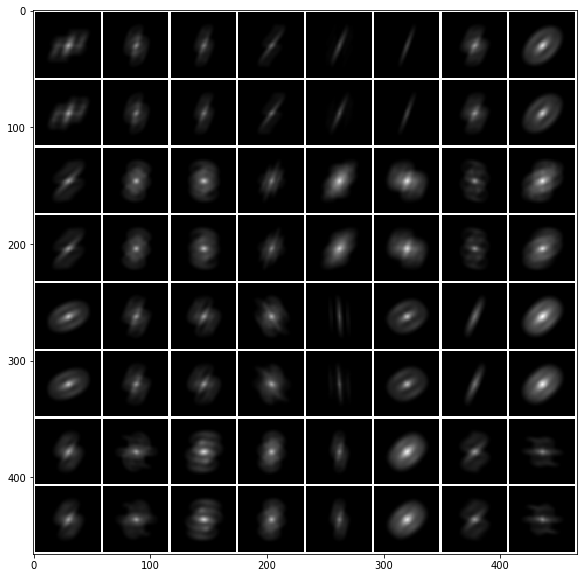

Mean squared dist: 0.74374276
Starting epoch 32
epoch: 32 	 step:0 	 loss: 0.6969
epoch: 32 	 step:100 	 loss: 0.6781
epoch: 32 	 step:200 	 loss: 0.7318
epoch: 32 	 step:300 	 loss: 0.7123
epoch: 32 	 step:400 	 loss: 0.7411
epoch: 32 	 step:500 	 loss: 0.7158
epoch: 32 	 step:600 	 loss: 0.6969
epoch: 32 	 step:700 	 loss: 0.7363
epoch: 32 	 step:800 	 loss: 0.7176
epoch: 32 	 step:900 	 loss: 0.7222
epoch: 32 	 step:1000 	 loss: 0.727
epoch: 32 	 step:1100 	 loss: 0.7199
epoch: 32 	 step:1200 	 loss: 0.7368
epoch: 32 	 step:1300 	 loss: 0.7098
epoch: 32 	 step:1400 	 loss: 0.7127
epoch: 32 	 step:1500 	 loss: 0.7077
epoch: 32 	 step:1600 	 loss: 0.7337
epoch: 32 	 step:1700 	 loss: 0.6909
epoch: 32 	 step:1800 	 loss: 0.7215


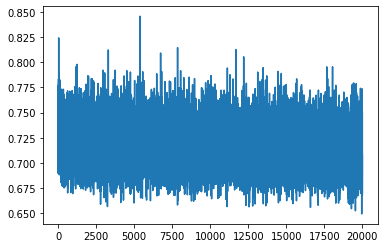

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


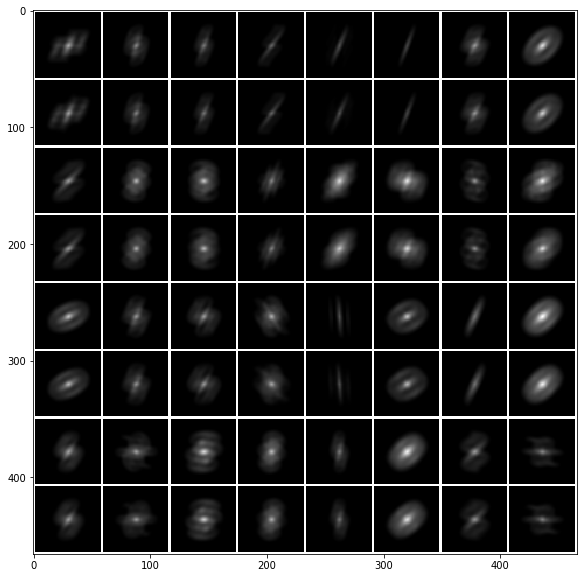

Mean squared dist: 0.88352495
Starting epoch 33
epoch: 33 	 step:0 	 loss: 0.721
epoch: 33 	 step:100 	 loss: 0.7089
epoch: 33 	 step:200 	 loss: 0.6908
epoch: 33 	 step:300 	 loss: 0.7191
epoch: 33 	 step:400 	 loss: 0.7099
epoch: 33 	 step:500 	 loss: 0.7167
epoch: 33 	 step:600 	 loss: 0.7056
epoch: 33 	 step:700 	 loss: 0.6977
epoch: 33 	 step:800 	 loss: 0.7211
epoch: 33 	 step:900 	 loss: 0.7028
epoch: 33 	 step:1000 	 loss: 0.6883
epoch: 33 	 step:1100 	 loss: 0.7133
epoch: 33 	 step:1200 	 loss: 0.6838
epoch: 33 	 step:1300 	 loss: 0.7404
epoch: 33 	 step:1400 	 loss: 0.6943
epoch: 33 	 step:1500 	 loss: 0.7427
epoch: 33 	 step:1600 	 loss: 0.7144
epoch: 33 	 step:1700 	 loss: 0.6783
epoch: 33 	 step:1800 	 loss: 0.7095


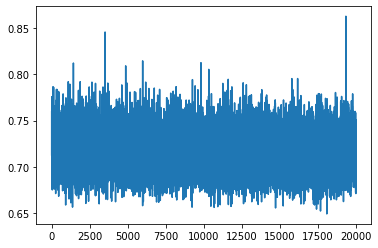

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


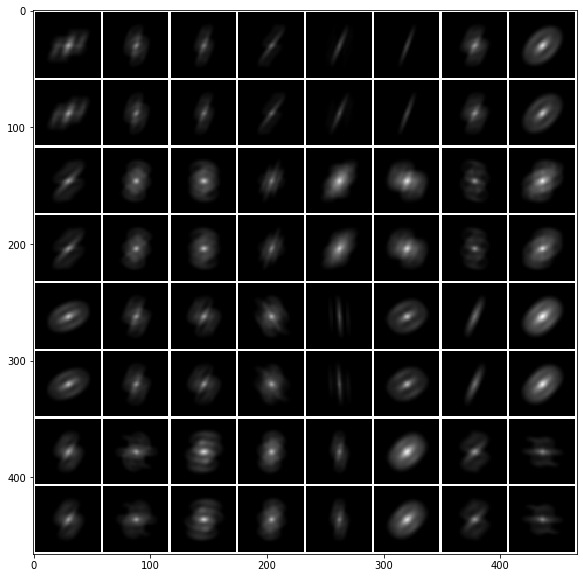

Mean squared dist: 0.9035549
Starting epoch 34
epoch: 34 	 step:0 	 loss: 0.7108
epoch: 34 	 step:100 	 loss: 0.6942
epoch: 34 	 step:200 	 loss: 0.6769
epoch: 34 	 step:300 	 loss: 0.7422
epoch: 34 	 step:400 	 loss: 0.7224
epoch: 34 	 step:500 	 loss: 0.7142
epoch: 34 	 step:600 	 loss: 0.7342
epoch: 34 	 step:700 	 loss: 0.7565
epoch: 34 	 step:800 	 loss: 0.7206
epoch: 34 	 step:900 	 loss: 0.7562
epoch: 34 	 step:1000 	 loss: 0.7149
epoch: 34 	 step:1100 	 loss: 0.7535
epoch: 34 	 step:1200 	 loss: 0.6942
epoch: 34 	 step:1300 	 loss: 0.7317
epoch: 34 	 step:1400 	 loss: 0.7192
epoch: 34 	 step:1500 	 loss: 0.6632
epoch: 34 	 step:1600 	 loss: 0.7154
epoch: 34 	 step:1700 	 loss: 0.698
epoch: 34 	 step:1800 	 loss: 0.7318


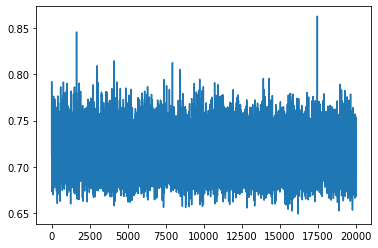

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


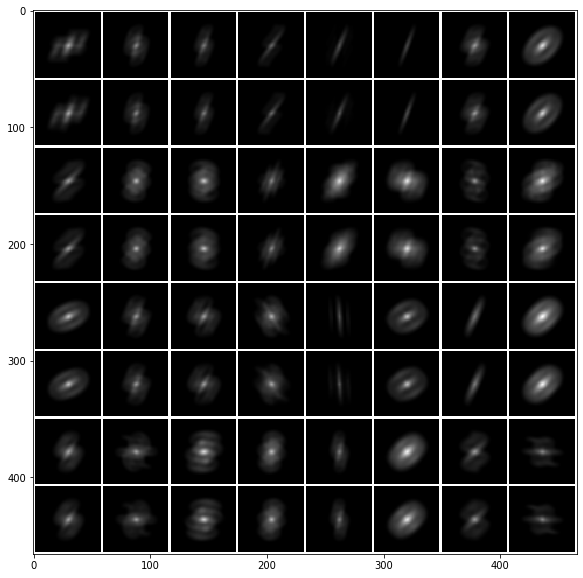

Mean squared dist: 0.84415495
Starting epoch 35
epoch: 35 	 step:0 	 loss: 0.7097
epoch: 35 	 step:100 	 loss: 0.7032
epoch: 35 	 step:200 	 loss: 0.7403
epoch: 35 	 step:300 	 loss: 0.7245
epoch: 35 	 step:400 	 loss: 0.6977
epoch: 35 	 step:500 	 loss: 0.7031
epoch: 35 	 step:600 	 loss: 0.7476
epoch: 35 	 step:700 	 loss: 0.7503
epoch: 35 	 step:800 	 loss: 0.7304
epoch: 35 	 step:900 	 loss: 0.7381
epoch: 35 	 step:1000 	 loss: 0.7236
epoch: 35 	 step:1100 	 loss: 0.7219
epoch: 35 	 step:1200 	 loss: 0.7328
epoch: 35 	 step:1300 	 loss: 0.7377
epoch: 35 	 step:1400 	 loss: 0.7319
epoch: 35 	 step:1500 	 loss: 0.7242
epoch: 35 	 step:1600 	 loss: 0.7113
epoch: 35 	 step:1700 	 loss: 0.688
epoch: 35 	 step:1800 	 loss: 0.7247


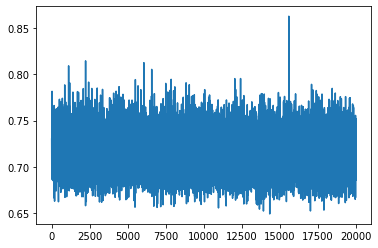

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


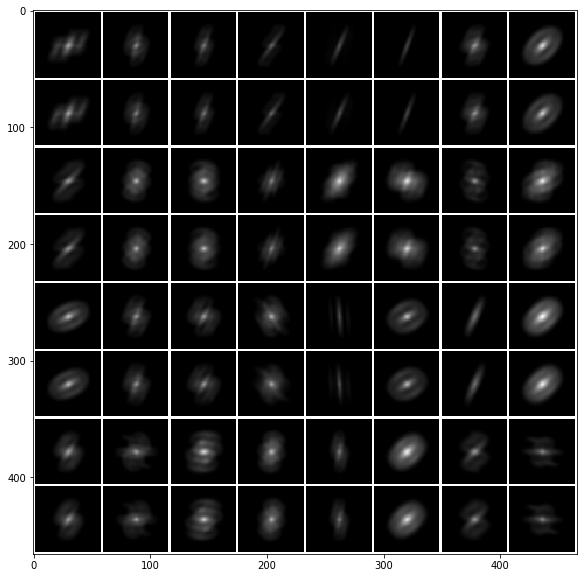

Mean squared dist: 0.6578609
Starting epoch 36
epoch: 36 	 step:0 	 loss: 0.7246
epoch: 36 	 step:100 	 loss: 0.7253
epoch: 36 	 step:200 	 loss: 0.7073
epoch: 36 	 step:300 	 loss: 0.7167
epoch: 36 	 step:400 	 loss: 0.748
epoch: 36 	 step:500 	 loss: 0.712
epoch: 36 	 step:600 	 loss: 0.744
epoch: 36 	 step:700 	 loss: 0.7165
epoch: 36 	 step:800 	 loss: 0.7205
epoch: 36 	 step:900 	 loss: 0.7064
epoch: 36 	 step:1000 	 loss: 0.7118
epoch: 36 	 step:1100 	 loss: 0.7167
epoch: 36 	 step:1200 	 loss: 0.7059
epoch: 36 	 step:1300 	 loss: 0.7399
epoch: 36 	 step:1400 	 loss: 0.6954
epoch: 36 	 step:1500 	 loss: 0.6984
epoch: 36 	 step:1600 	 loss: 0.7168
epoch: 36 	 step:1700 	 loss: 0.7412
epoch: 36 	 step:1800 	 loss: 0.7091


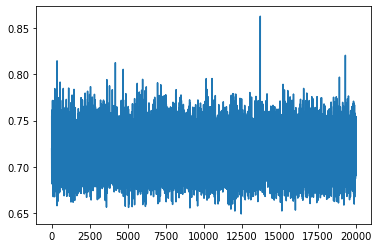

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


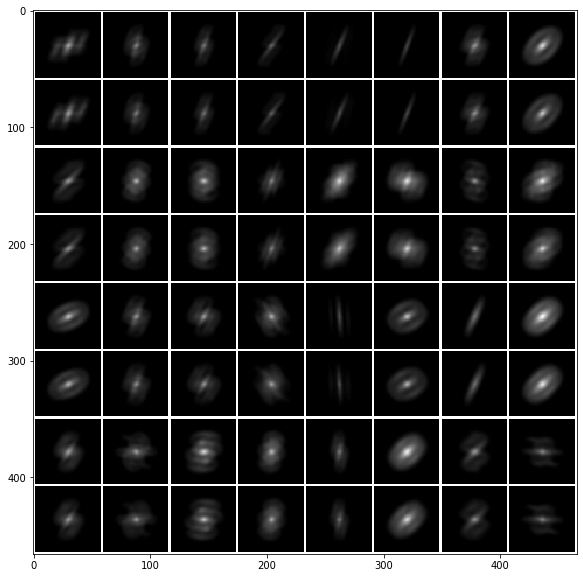

Mean squared dist: 1.241087
Starting epoch 37
epoch: 37 	 step:0 	 loss: 0.7303
epoch: 37 	 step:100 	 loss: 0.688
epoch: 37 	 step:200 	 loss: 0.7157
epoch: 37 	 step:300 	 loss: 0.6912
epoch: 37 	 step:400 	 loss: 0.6924
epoch: 37 	 step:500 	 loss: 0.7582
epoch: 37 	 step:600 	 loss: 0.7341
epoch: 37 	 step:700 	 loss: 0.7029
epoch: 37 	 step:800 	 loss: 0.7273
epoch: 37 	 step:900 	 loss: 0.7424
epoch: 37 	 step:1000 	 loss: 0.7057
epoch: 37 	 step:1100 	 loss: 0.7202
epoch: 37 	 step:1200 	 loss: 0.7149
epoch: 37 	 step:1300 	 loss: 0.6951
epoch: 37 	 step:1400 	 loss: 0.701
epoch: 37 	 step:1500 	 loss: 0.7292
epoch: 37 	 step:1600 	 loss: 0.7145
epoch: 37 	 step:1700 	 loss: 0.7278
epoch: 37 	 step:1800 	 loss: 0.7138


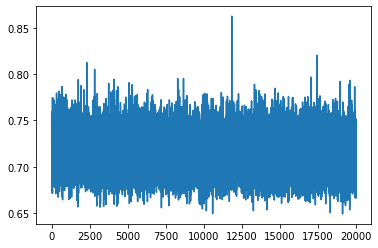

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


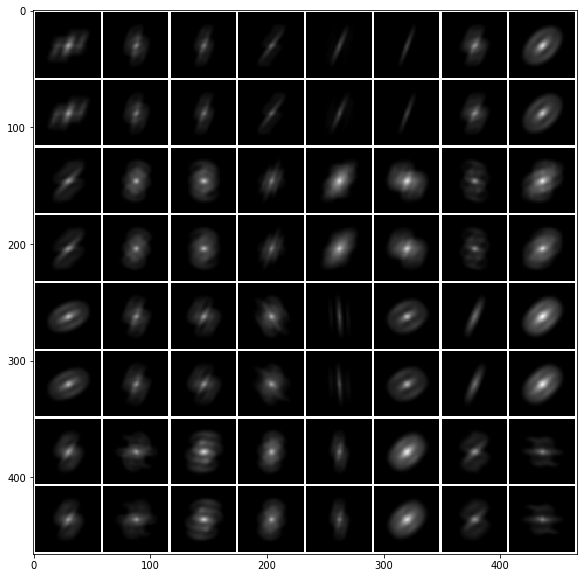

Mean squared dist: 0.7752167
Starting epoch 38
epoch: 38 	 step:0 	 loss: 0.7004
epoch: 38 	 step:100 	 loss: 0.7346
epoch: 38 	 step:200 	 loss: 0.7273
epoch: 38 	 step:300 	 loss: 0.7203
epoch: 38 	 step:400 	 loss: 0.7273
epoch: 38 	 step:500 	 loss: 0.7189
epoch: 38 	 step:600 	 loss: 0.697
epoch: 38 	 step:700 	 loss: 0.7062
epoch: 38 	 step:800 	 loss: 0.717
epoch: 38 	 step:900 	 loss: 0.7401
epoch: 38 	 step:1000 	 loss: 0.7028
epoch: 38 	 step:1100 	 loss: 0.7151
epoch: 38 	 step:1200 	 loss: 0.7615
epoch: 38 	 step:1300 	 loss: 0.6927
epoch: 38 	 step:1400 	 loss: 0.7112
epoch: 38 	 step:1500 	 loss: 0.7279
epoch: 38 	 step:1600 	 loss: 0.744
epoch: 38 	 step:1700 	 loss: 0.7204
epoch: 38 	 step:1800 	 loss: 0.6839


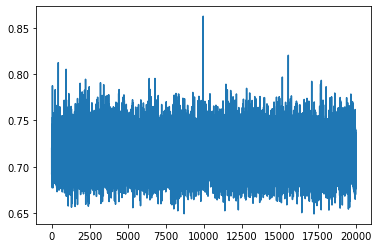

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


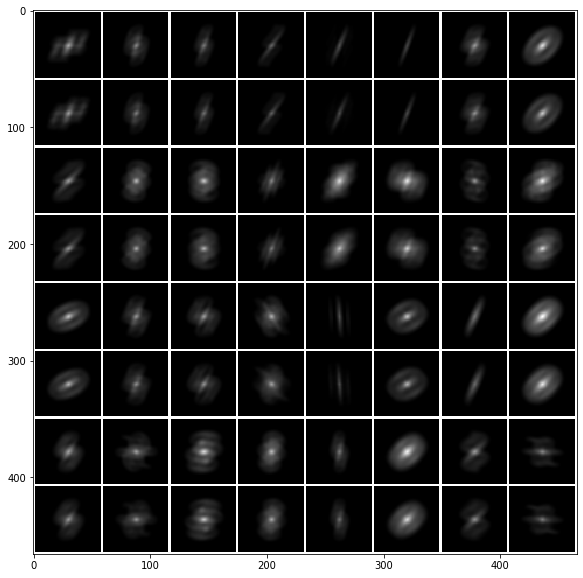

Mean squared dist: 1.4883549
Starting epoch 39
epoch: 39 	 step:0 	 loss: 0.7353
epoch: 39 	 step:100 	 loss: 0.7378
epoch: 39 	 step:200 	 loss: 0.7272
epoch: 39 	 step:300 	 loss: 0.7351
epoch: 39 	 step:400 	 loss: 0.7153
epoch: 39 	 step:500 	 loss: 0.6513
epoch: 39 	 step:600 	 loss: 0.7395
epoch: 39 	 step:700 	 loss: 0.7168
epoch: 39 	 step:800 	 loss: 0.7128
epoch: 39 	 step:900 	 loss: 0.6879
epoch: 39 	 step:1000 	 loss: 0.6918
epoch: 39 	 step:1100 	 loss: 0.6817
epoch: 39 	 step:1200 	 loss: 0.7458
epoch: 39 	 step:1300 	 loss: 0.6942
epoch: 39 	 step:1400 	 loss: 0.6895
epoch: 39 	 step:1500 	 loss: 0.7237
epoch: 39 	 step:1600 	 loss: 0.7189
epoch: 39 	 step:1700 	 loss: 0.6841
epoch: 39 	 step:1800 	 loss: 0.7433


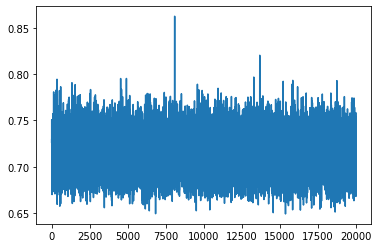

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


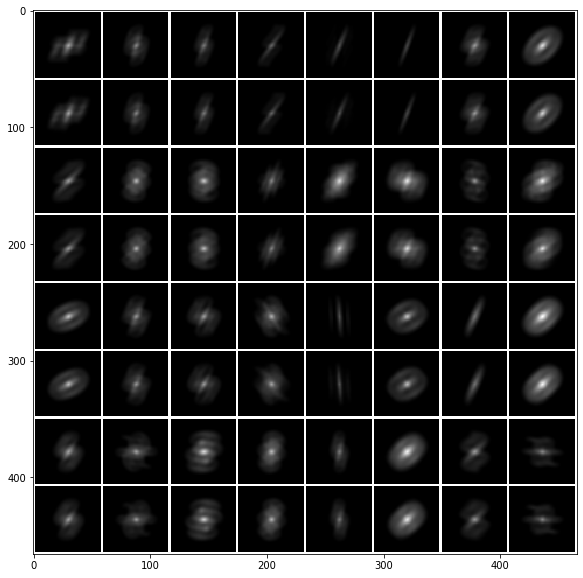

Mean squared dist: 0.6981902
Starting epoch 40
epoch: 40 	 step:0 	 loss: 0.7089
epoch: 40 	 step:100 	 loss: 0.7189
epoch: 40 	 step:200 	 loss: 0.6942
epoch: 40 	 step:300 	 loss: 0.7286
epoch: 40 	 step:400 	 loss: 0.6832
epoch: 40 	 step:500 	 loss: 0.7353
epoch: 40 	 step:600 	 loss: 0.7018
epoch: 40 	 step:700 	 loss: 0.7222
epoch: 40 	 step:800 	 loss: 0.7397
epoch: 40 	 step:900 	 loss: 0.705
epoch: 40 	 step:1000 	 loss: 0.7199
epoch: 40 	 step:1100 	 loss: 0.7182
epoch: 40 	 step:1200 	 loss: 0.711
epoch: 40 	 step:1300 	 loss: 0.7168
epoch: 40 	 step:1400 	 loss: 0.7099
epoch: 40 	 step:1500 	 loss: 0.726
epoch: 40 	 step:1600 	 loss: 0.7274
epoch: 40 	 step:1700 	 loss: 0.6934
epoch: 40 	 step:1800 	 loss: 0.719


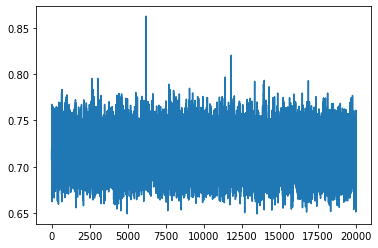

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


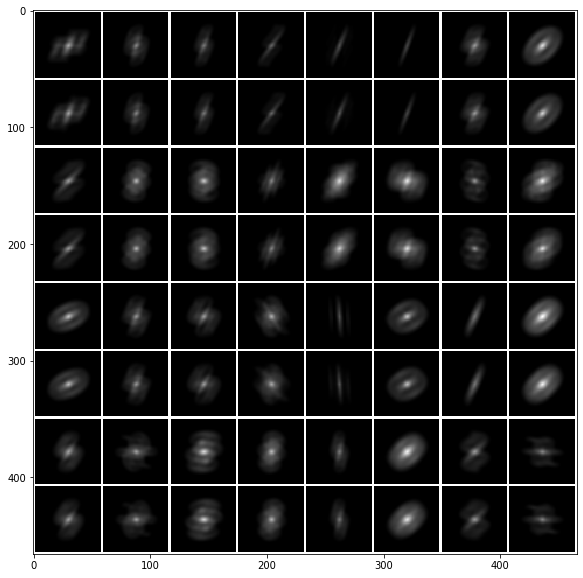

Mean squared dist: 0.64742464
Starting epoch 41
epoch: 41 	 step:0 	 loss: 0.7075
epoch: 41 	 step:100 	 loss: 0.6789
epoch: 41 	 step:200 	 loss: 0.7383
epoch: 41 	 step:300 	 loss: 0.7087
epoch: 41 	 step:400 	 loss: 0.6993
epoch: 41 	 step:500 	 loss: 0.7289
epoch: 41 	 step:600 	 loss: 0.708
epoch: 41 	 step:700 	 loss: 0.6858
epoch: 41 	 step:800 	 loss: 0.6981
epoch: 41 	 step:900 	 loss: 0.7217
epoch: 41 	 step:1000 	 loss: 0.7427
epoch: 41 	 step:1100 	 loss: 0.7086
epoch: 41 	 step:1200 	 loss: 0.7195
epoch: 41 	 step:1300 	 loss: 0.6705
epoch: 41 	 step:1400 	 loss: 0.6988
epoch: 41 	 step:1500 	 loss: 0.7344
epoch: 41 	 step:1600 	 loss: 0.7376
epoch: 41 	 step:1700 	 loss: 0.7028
epoch: 41 	 step:1800 	 loss: 0.7166


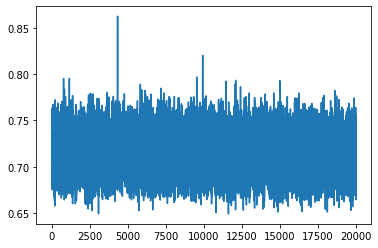

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


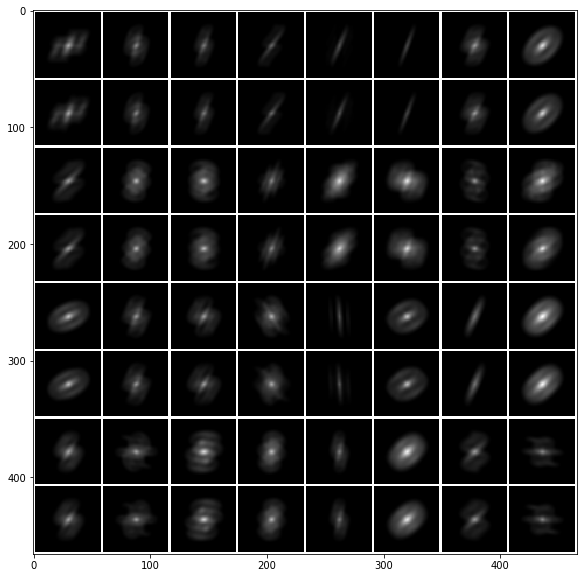

Mean squared dist: 0.7225675
Starting epoch 42
epoch: 42 	 step:0 	 loss: 0.739
epoch: 42 	 step:100 	 loss: 0.7188
epoch: 42 	 step:200 	 loss: 0.706
epoch: 42 	 step:300 	 loss: 0.7264
epoch: 42 	 step:400 	 loss: 0.7202
epoch: 42 	 step:500 	 loss: 0.7118
epoch: 42 	 step:600 	 loss: 0.6897
epoch: 42 	 step:700 	 loss: 0.7158
epoch: 42 	 step:800 	 loss: 0.7245
epoch: 42 	 step:900 	 loss: 0.7027
epoch: 42 	 step:1000 	 loss: 0.7113
epoch: 42 	 step:1100 	 loss: 0.7078
epoch: 42 	 step:1200 	 loss: 0.71
epoch: 42 	 step:1300 	 loss: 0.731
epoch: 42 	 step:1400 	 loss: 0.7244
epoch: 42 	 step:1500 	 loss: 0.6823
epoch: 42 	 step:1600 	 loss: 0.7228
epoch: 42 	 step:1700 	 loss: 0.6828
epoch: 42 	 step:1800 	 loss: 0.7105


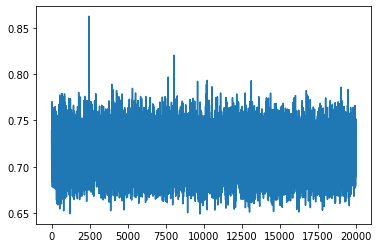

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


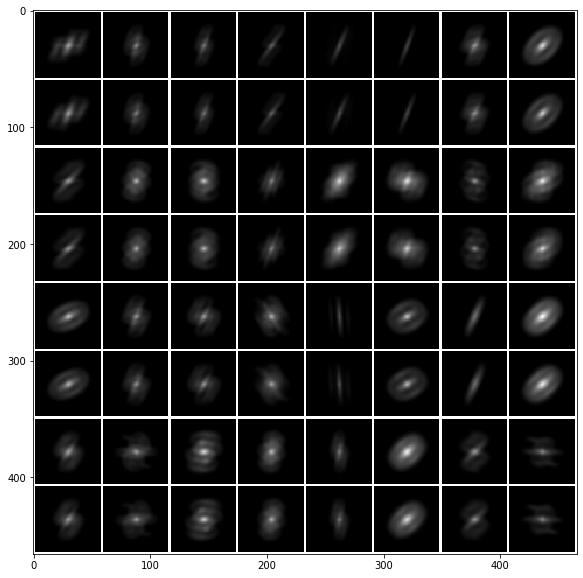

Mean squared dist: 0.9107891
Starting epoch 43
epoch: 43 	 step:0 	 loss: 0.6889
epoch: 43 	 step:100 	 loss: 0.6964
epoch: 43 	 step:200 	 loss: 0.7171
epoch: 43 	 step:300 	 loss: 0.703
epoch: 43 	 step:400 	 loss: 0.706
epoch: 43 	 step:500 	 loss: 0.7029
epoch: 43 	 step:600 	 loss: 0.7329
epoch: 43 	 step:700 	 loss: 0.7075
epoch: 43 	 step:800 	 loss: 0.736
epoch: 43 	 step:900 	 loss: 0.7228
epoch: 43 	 step:1000 	 loss: 0.6885
epoch: 43 	 step:1100 	 loss: 0.7025
epoch: 43 	 step:1200 	 loss: 0.7293
epoch: 43 	 step:1300 	 loss: 0.705
epoch: 43 	 step:1400 	 loss: 0.7557
epoch: 43 	 step:1500 	 loss: 0.7173
epoch: 43 	 step:1600 	 loss: 0.707
epoch: 43 	 step:1700 	 loss: 0.721
epoch: 43 	 step:1800 	 loss: 0.7416


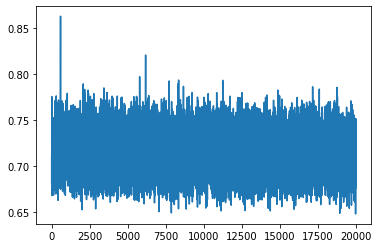

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


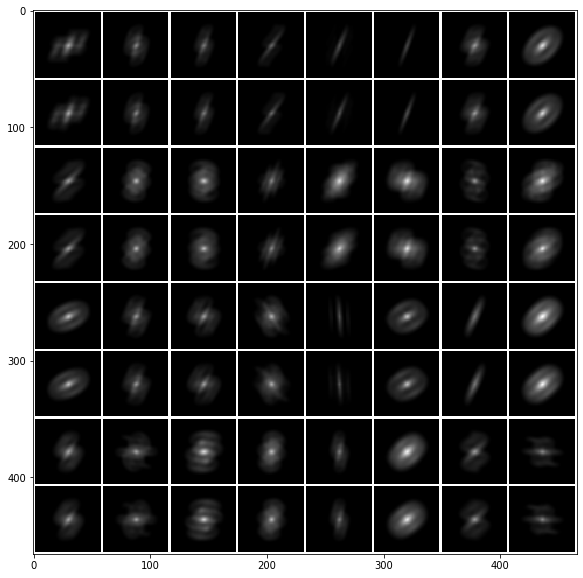

Mean squared dist: 0.6484223
Starting epoch 44
epoch: 44 	 step:0 	 loss: 0.7087
epoch: 44 	 step:100 	 loss: 0.7493
epoch: 44 	 step:200 	 loss: 0.6838
epoch: 44 	 step:300 	 loss: 0.6902
epoch: 44 	 step:400 	 loss: 0.6761
epoch: 44 	 step:500 	 loss: 0.7239
epoch: 44 	 step:600 	 loss: 0.7231
epoch: 44 	 step:700 	 loss: 0.7689
epoch: 44 	 step:800 	 loss: 0.7216
epoch: 44 	 step:900 	 loss: 0.6949
epoch: 44 	 step:1000 	 loss: 0.7107
epoch: 44 	 step:1100 	 loss: 0.6812
epoch: 44 	 step:1200 	 loss: 0.7073
epoch: 44 	 step:1300 	 loss: 0.7279
epoch: 44 	 step:1400 	 loss: 0.6951
epoch: 44 	 step:1500 	 loss: 0.6996
epoch: 44 	 step:1600 	 loss: 0.7325
epoch: 44 	 step:1700 	 loss: 0.6977
epoch: 44 	 step:1800 	 loss: 0.7358


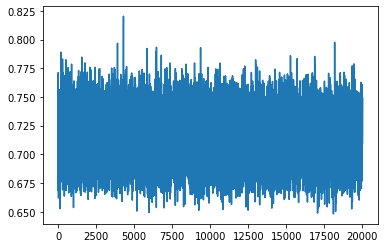

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


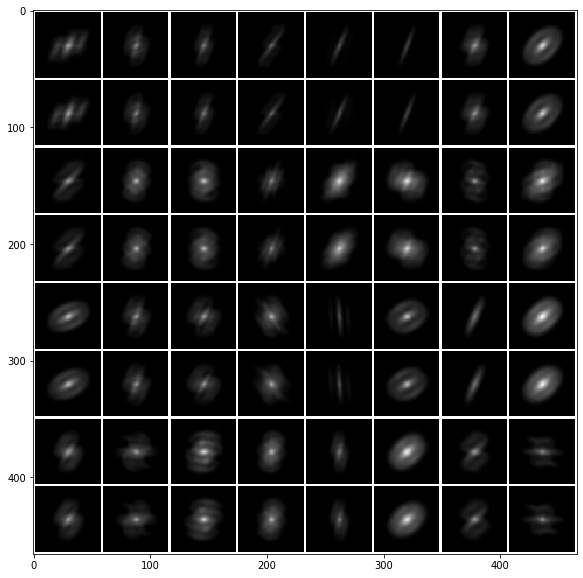

Mean squared dist: 0.6127069
Starting epoch 45
epoch: 45 	 step:0 	 loss: 0.7021
epoch: 45 	 step:100 	 loss: 0.7326
epoch: 45 	 step:200 	 loss: 0.7189
epoch: 45 	 step:300 	 loss: 0.7438
epoch: 45 	 step:400 	 loss: 0.7436
epoch: 45 	 step:500 	 loss: 0.6808
epoch: 45 	 step:600 	 loss: 0.6933
epoch: 45 	 step:700 	 loss: 0.6772
epoch: 45 	 step:800 	 loss: 0.7405
epoch: 45 	 step:900 	 loss: 0.7247
epoch: 45 	 step:1000 	 loss: 0.7628
epoch: 45 	 step:1100 	 loss: 0.7337
epoch: 45 	 step:1200 	 loss: 0.7147
epoch: 45 	 step:1300 	 loss: 0.7389
epoch: 45 	 step:1400 	 loss: 0.7292
epoch: 45 	 step:1500 	 loss: 0.6844
epoch: 45 	 step:1600 	 loss: 0.7031
epoch: 45 	 step:1700 	 loss: 0.7245
epoch: 45 	 step:1800 	 loss: 0.71


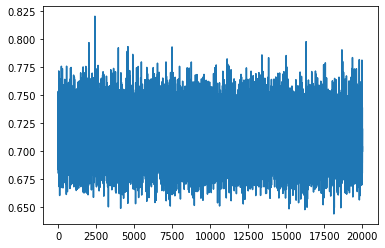

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


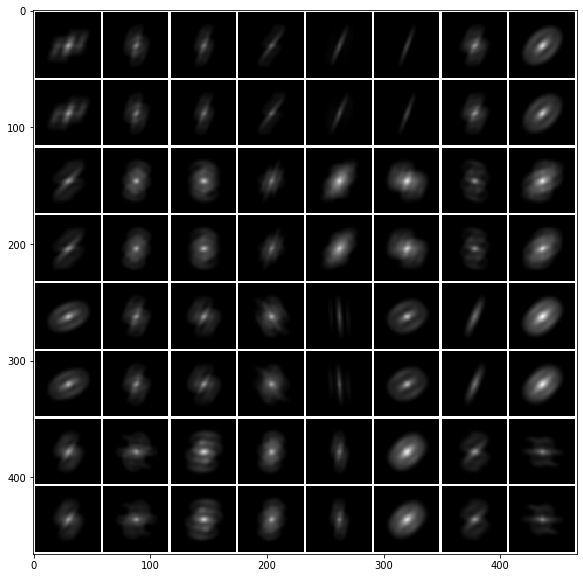

Mean squared dist: 0.60996395
Starting epoch 46
epoch: 46 	 step:0 	 loss: 0.7038
epoch: 46 	 step:100 	 loss: 0.7247
epoch: 46 	 step:200 	 loss: 0.7281
epoch: 46 	 step:300 	 loss: 0.7187
epoch: 46 	 step:400 	 loss: 0.6992
epoch: 46 	 step:500 	 loss: 0.7052
epoch: 46 	 step:600 	 loss: 0.6981
epoch: 46 	 step:700 	 loss: 0.7155
epoch: 46 	 step:800 	 loss: 0.7282
epoch: 46 	 step:900 	 loss: 0.7125
epoch: 46 	 step:1000 	 loss: 0.7162
epoch: 46 	 step:1100 	 loss: 0.7222
epoch: 46 	 step:1200 	 loss: 0.7309
epoch: 46 	 step:1300 	 loss: 0.6896
epoch: 46 	 step:1400 	 loss: 0.7144
epoch: 46 	 step:1500 	 loss: 0.6906
epoch: 46 	 step:1600 	 loss: 0.705
epoch: 46 	 step:1700 	 loss: 0.7208
epoch: 46 	 step:1800 	 loss: 0.6832


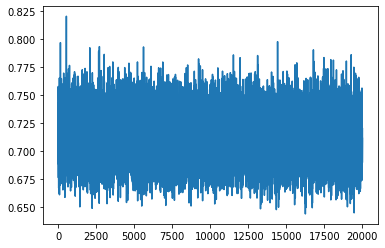

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


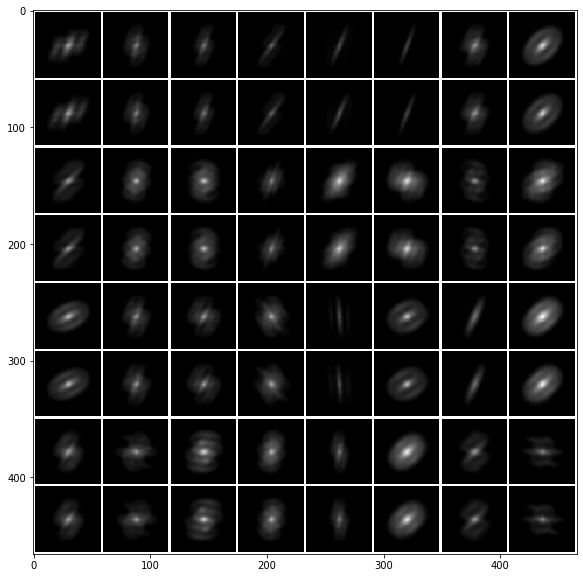

Mean squared dist: 0.8475957
Starting epoch 47
epoch: 47 	 step:0 	 loss: 0.6982
epoch: 47 	 step:100 	 loss: 0.7062
epoch: 47 	 step:200 	 loss: 0.7138
epoch: 47 	 step:300 	 loss: 0.7388
epoch: 47 	 step:400 	 loss: 0.7348
epoch: 47 	 step:500 	 loss: 0.724
epoch: 47 	 step:600 	 loss: 0.7135
epoch: 47 	 step:700 	 loss: 0.7117
epoch: 47 	 step:800 	 loss: 0.7299
epoch: 47 	 step:900 	 loss: 0.6928
epoch: 47 	 step:1000 	 loss: 0.7124
epoch: 47 	 step:1100 	 loss: 0.7058
epoch: 47 	 step:1200 	 loss: 0.7256
epoch: 47 	 step:1300 	 loss: 0.7523
epoch: 47 	 step:1400 	 loss: 0.707
epoch: 47 	 step:1500 	 loss: 0.7359
epoch: 47 	 step:1600 	 loss: 0.7173
epoch: 47 	 step:1700 	 loss: 0.6939
epoch: 47 	 step:1800 	 loss: 0.6876


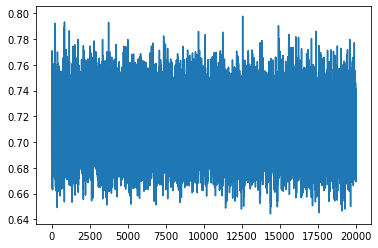

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


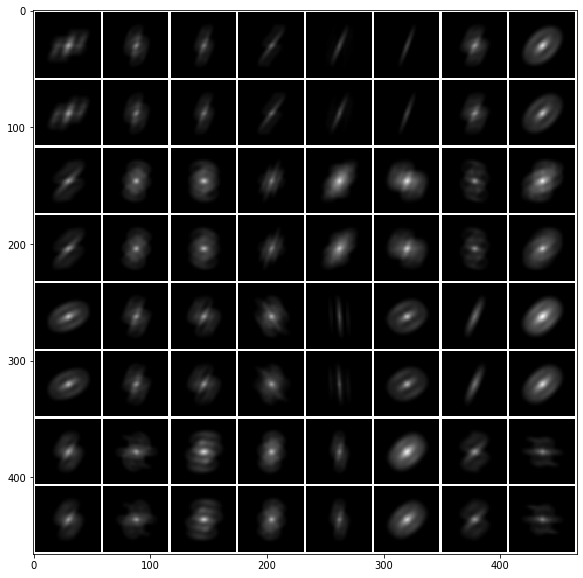

Mean squared dist: 1.2754623
Starting epoch 48
epoch: 48 	 step:0 	 loss: 0.7155
epoch: 48 	 step:100 	 loss: 0.7738
epoch: 48 	 step:200 	 loss: 0.682
epoch: 48 	 step:300 	 loss: 0.7124
epoch: 48 	 step:400 	 loss: 0.7041
epoch: 48 	 step:500 	 loss: 0.7115
epoch: 48 	 step:600 	 loss: 0.7215
epoch: 48 	 step:700 	 loss: 0.7182
epoch: 48 	 step:800 	 loss: 0.7219
epoch: 48 	 step:900 	 loss: 0.7494
epoch: 48 	 step:1000 	 loss: 0.7332
epoch: 48 	 step:1100 	 loss: 0.6947
epoch: 48 	 step:1200 	 loss: 0.7106
epoch: 48 	 step:1300 	 loss: 0.71
epoch: 48 	 step:1400 	 loss: 0.7175
epoch: 48 	 step:1500 	 loss: 0.6968
epoch: 48 	 step:1600 	 loss: 0.6873
epoch: 48 	 step:1700 	 loss: 0.7581
epoch: 48 	 step:1800 	 loss: 0.7331


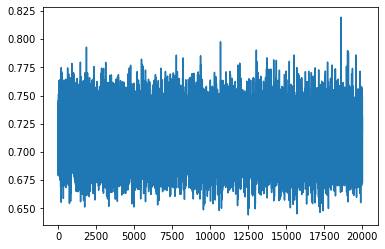

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


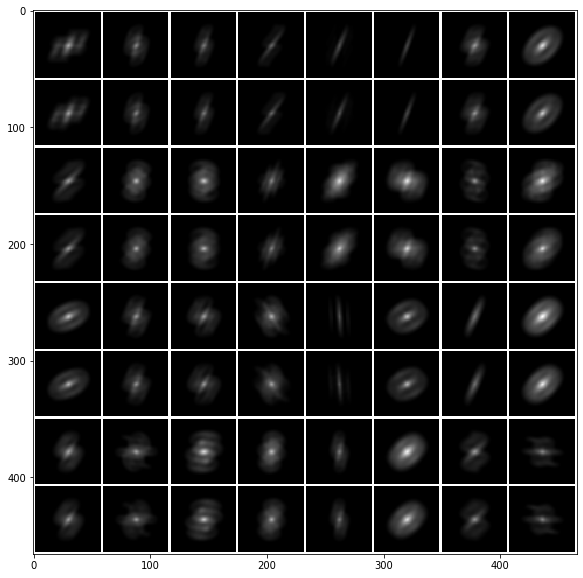

Mean squared dist: 1.3062173
Starting epoch 49
epoch: 49 	 step:0 	 loss: 0.73
epoch: 49 	 step:100 	 loss: 0.7105
epoch: 49 	 step:200 	 loss: 0.7481
epoch: 49 	 step:300 	 loss: 0.7141
epoch: 49 	 step:400 	 loss: 0.711
epoch: 49 	 step:500 	 loss: 0.6827
epoch: 49 	 step:600 	 loss: 0.7224
epoch: 49 	 step:700 	 loss: 0.7271
epoch: 49 	 step:800 	 loss: 0.6858
epoch: 49 	 step:900 	 loss: 0.6998
epoch: 49 	 step:1000 	 loss: 0.7212
epoch: 49 	 step:1100 	 loss: 0.7185
epoch: 49 	 step:1200 	 loss: 0.718
epoch: 49 	 step:1300 	 loss: 0.6837
epoch: 49 	 step:1400 	 loss: 0.7222
epoch: 49 	 step:1500 	 loss: 0.6867
epoch: 49 	 step:1600 	 loss: 0.7132
epoch: 49 	 step:1700 	 loss: 0.6939
epoch: 49 	 step:1800 	 loss: 0.6857


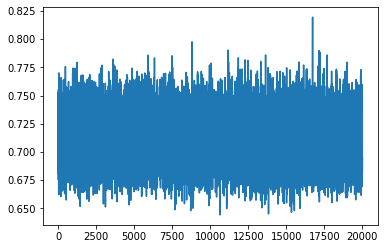

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


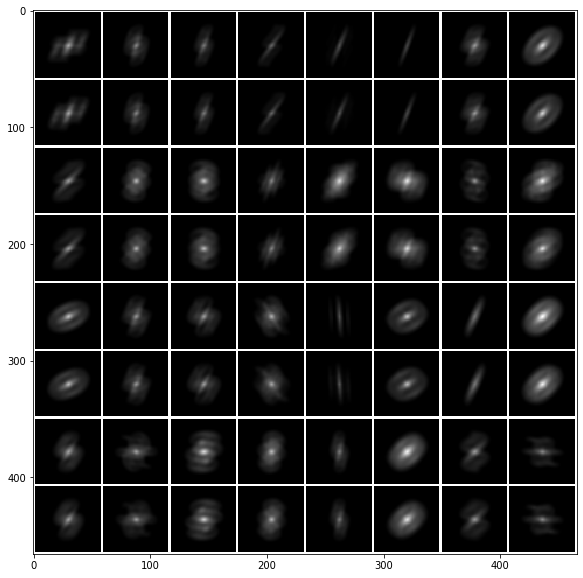

Mean squared dist: 0.65153515
Starting epoch 50
epoch: 50 	 step:0 	 loss: 0.7192
epoch: 50 	 step:100 	 loss: 0.6944
epoch: 50 	 step:200 	 loss: 0.7166
epoch: 50 	 step:300 	 loss: 0.7057
epoch: 50 	 step:400 	 loss: 0.6752
epoch: 50 	 step:500 	 loss: 0.725
epoch: 50 	 step:600 	 loss: 0.7353
epoch: 50 	 step:700 	 loss: 0.6859
epoch: 50 	 step:800 	 loss: 0.7107
epoch: 50 	 step:900 	 loss: 0.728
epoch: 50 	 step:1000 	 loss: 0.707
epoch: 50 	 step:1100 	 loss: 0.7291
epoch: 50 	 step:1200 	 loss: 0.705
epoch: 50 	 step:1300 	 loss: 0.7327
epoch: 50 	 step:1400 	 loss: 0.6918
epoch: 50 	 step:1500 	 loss: 0.7513
epoch: 50 	 step:1600 	 loss: 0.6967
epoch: 50 	 step:1700 	 loss: 0.7281
epoch: 50 	 step:1800 	 loss: 0.7063


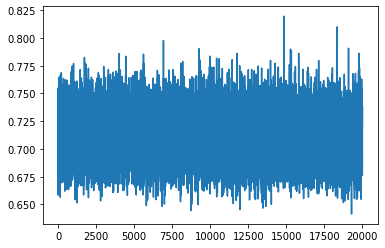

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


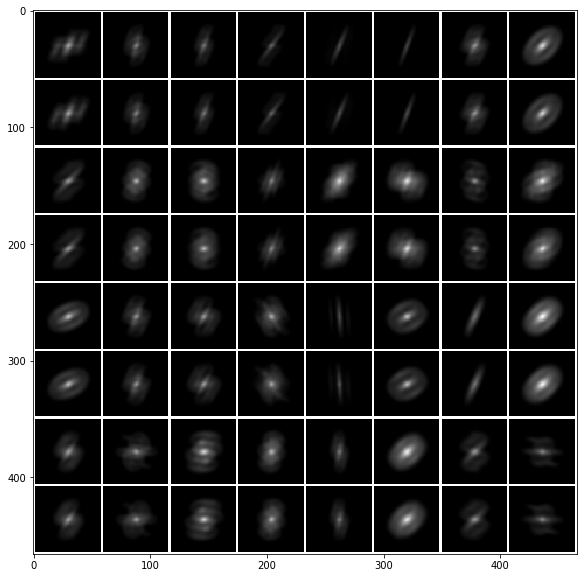

Mean squared dist: 0.50655645


In [101]:
### TRAIN MODEL ###

import time
num_epochs = 50

history, loss_val = train_model(gen, opt, device, dataloader['train'], epochs=num_epochs)

gen_weights = gen.state_dict().copy()

torch.save(gen_weights, "../cache/auto/MNIST_AutoNet_{0:04d}_{1}.sd".format(num_epochs, time.strftime("%Y%m%d_%H%M%S")));

True padded magnitudes


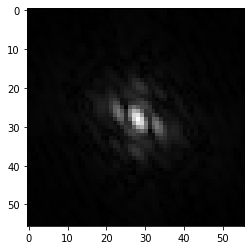

True magnitudes


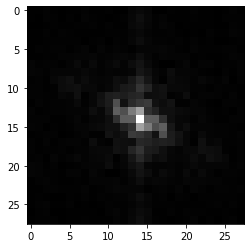

Predicted padded magnitudes


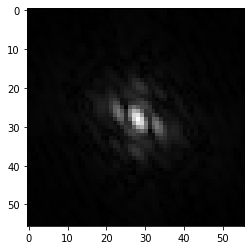

In [219]:
pred_autocorr = gen(calc_circ_autocorr(sample[0]).to(device))[0]
magn = calc_magn(sample[0]).detach().cpu().numpy()
magn_pad = torch.sqrt(calc_magn(pred_autocorr)).detach().cpu().numpy()

print("True padded magnitudes")
plot(fftshift(magn_pad / magn_pad.max()))

print("True magnitudes")
plot(fftshift(magn / magn.max()))

print("Predicted padded magnitudes")
pred_magn_pad = torch.sqrt(calc_magn(pred_autocorr)).detach().cpu().numpy()
plot(fftshift(pred_magn_pad / pred_magn_pad.max()))

# Optimization through other models


### 1. HIO
---

In [214]:
def fourier_constraints(x, magn):
    x_hat = np.fft.fft2(x)
    y_hat = magn * np.exp(1j * np.angle(x_hat))
    return np.real(np.fft.ifft2(y_hat))
    
def signal_constraints(x, y, beta, mask=None):
        if mask is None:
            indices = y < 0
        else:
            indices = np.logical_or(np.logical_and(y<0, mask), np.logical_not(mask))
        y[indices] = x[indices] - beta * y[indices]
        return y

def hio(mag_pad, magn, mask, beta=0.8, steps=200, verbose=True):

    # random init 
    x = np.random.rand(*mag_pad.shape)
    y = fourier_constraints(x, magn_pad)
    
    p = (mag_pad.shape[-1] - magn.shape[-1]) // 2
     
    # main loop
    for i in range(1, steps+1):
        # show progress
        if i % 100 == 0 and verbose: 
            print("step", i, "of", steps)

        x = signal_constraints(x, y, beta, mask)
        y = fourier_constraints(x, magn_pad)
        
        # Additional constraints of real measured magnitude
        y_in = fourier_constraints(unpad(y), magn)
        y[..., p:3*p, p:3*p] = y_in

    return y_in

0


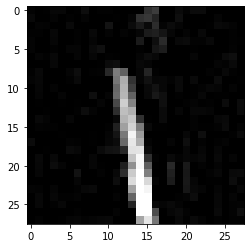

In [218]:
size = 32
restart = 3

beta = 0.8
steps = 1000

mask = np.pad(np.ones((1, 28, 28)), ((0, 0), (14, 14), (14, 14)), mode='constant')

test_data = dataloader['test'].dataset
results = np.empty((size, 1, 28, 28))
trues = np.empty((size, 1, 28, 28))
for i in range(size):
    if i % 50==0:
        print(i)
    trues[i] = test_data[i]
    pred_autocorr = gen(calc_circ_autocorr(test_data[i]).to(device))[0]
    magn = calc_magn(test_data[i]).detach().cpu().numpy()
    magn_pad = torch.sqrt(calc_magn(pred_autocorr)).detach().cpu().numpy()
    res = []
    errors = []
    for _ in range(restart):
        res.append(hio(magn_pad, magn, mask=mask, beta=beta, steps=steps, verbose=False))
        errors.append(np.mean((np.abs(np.fft.fft2(res[-1])) - magn) ** 2))
    #results[i] = unpad(res[np.argmin(errors)])
    results[i] = res[np.argmin(errors)]
    
plot(results[-1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


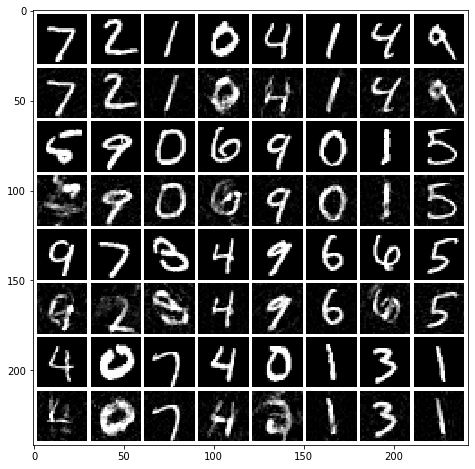

In [220]:
from util import register_croco

results_reg = register_croco(results, trues)

to_plot = np.stack([trues[:32, 0].reshape(4, 8, 28, 28), 
                    results_reg[:32, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)             
plot_grid(to_plot, figsize=(8,8))

In [221]:
# Benchmark test predictions #

benchmark(pred=trues[:1024], true=results[:1024], check_all=True)

Signal error:
  MSE: 0.14496341010981006, std: 0.055607070734765354
  MAE: 0.2073983885450208, std: 0.06377835343578454
  SSIM: 0.13181568064308166, std: 0.1640598596059554
  Sharpness: 0.14693017249836846, std: 0.056923889159195294
  PhCo-MSE: 0.03232674593122194, std: 0.04193054015981809
  PhCo-MAE: 0.09120019587213249, std: 0.058953740249194746
  PhCo-SSIM: 0.6377014908167384, std: 0.20907183593475903
  CroCo-MSE: 0.02497741794793218, std: 0.02480691111806395
  CroCo-MAE: 0.08387394324301034, std: 0.04448469636946405
  CroCo-SSIM: 0.6680567028256555, std: 0.15860141187003074

Magnitude error:
  MSE Magnitude: 5.341606061859384e-13, std: 2.395183422276849e-13

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]

Markdown table values:
 0.1450 | 0.2074 | 0.1318 | 0.1469 | 0.03233 | 0.09120 | 0.6377 | 0.02498 | 0.08387 | 0.6681 | 0.0000000000005342 |


### 2. DPR
---

In [228]:
### LOAD MODEL ###

latent_dim = 128
hidden_dim = 500

vae = models.SignalVAE(shape=imsize, latent_dim=latent_dim, hidden_dim=hidden_dim)
vae.load_state_dict(torch.load("../cache/models/VAE_MNIST/FC-VAE128Mnist_5.sd"));

Version 4


In [230]:
### Hand Paper (adapted) ###

def vaeopt(sample_magnitudes, vae, device, measurement_fn=calc_magn,
           z_shape=(20, 1, 1), optim_lr=1e-1, max_steps=5000):
    
    vae.to(device)
    vae.eval()
    
    N = sample_magnitudes.shape[0]

    z = torch.randn((N, *z_shape), requires_grad=True, device=device)

    optimizer = optim.Adam([z], lr=optim_lr)
    
    losses = []
    last_out = vae.decoder(z)
    
    for i in range(max_steps):
 
        magnitudes = measurement_fn(last_out)
        mse_all = torch.mean((magnitudes - sample_magnitudes) ** 2, dim=tuple(np.arange(len(magnitudes.shape))[1:]))
        loss = torch.sum(mse_all)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        last_out = vae.decoder(z)

        losses.append(loss.detach().cpu().item())
        
    return last_out.detach(), losses, mse_all

Batch 1/1 finished


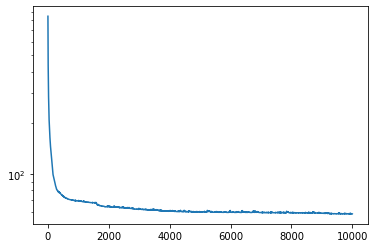

In [243]:
### Test one sample Fourier magnitudes random init + multiple restarts ###

num_batches = 1
batch_size = 32
max_steps = 10000
max_loss = 0.0
optim_lr = 1e-1
restarts = 3

###

out_original = np.zeros((batch_size * num_batches, *imsize))
out_results = np.zeros((batch_size * num_batches, *imsize))
mse_all = np.full((batch_size * num_batches), np.inf)

for batch_i, batch in enumerate(dataloader['test']):
    test_sample = batch.to(device)

    pred_autocorr = gen(calc_circ_autocorr(test_sample).to(device)).detach()
    magn = calc_magn(test_sample)
    magn_pad = torch.sqrt(calc_magn(pred_autocorr))
    
    out_original[batch_size * batch_i : batch_size * batch_i + batch_size] = test_sample.cpu().numpy()
    
    for r in range(restarts):
        cur_out_results, cur_loss, cur_mse_all = vaeopt(sample_magnitudes=magn_pad, vae=vae, device=device,
                                                        measurement_fn=lambda x: calc_magn(pad(x)),
                                                        z_shape=(latent_dim, ), optim_lr=optim_lr, max_steps=max_steps)
        cur_out_results = cur_out_results.cpu().numpy()

        for i in range(batch_size):
            mse = mse_all[batch_size * batch_i + i]
            if cur_mse_all[i] < mse:
                out_results[batch_size * batch_i + i] = cur_out_results[i]
                mse_all[batch_size * batch_i + i] = cur_mse_all[i]
    
    print("Batch {0}/{1} finished".format(batch_i + 1, num_batches))
    if batch_i + 1 >= num_batches:
        break

plt.semilogy(cur_loss)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


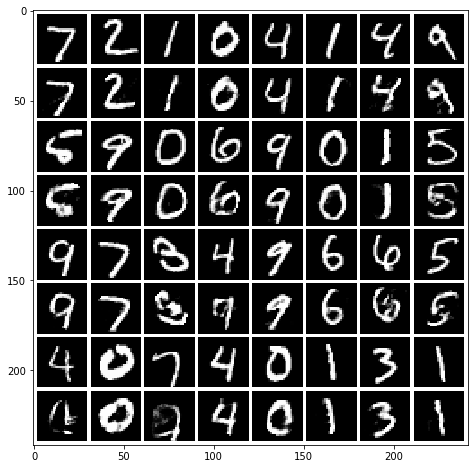

In [240]:
from util import register_croco

results_reg = register_croco(out_results, out_original)

to_plot = np.stack([out_original[:32, 0].reshape(4, 8, 28, 28), 
                    results_reg[:32, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)             
plot_grid(to_plot, figsize=(8,8))

In [241]:
# Benchmark test predictions #

benchmark(pred=results_reg[:1024], true=out_original[:1024], check_all=True)

Signal error:
  MSE: 0.02232486991838111, std: 0.014134658379082175
  MAE: 0.04702833047155379, std: 0.021674552705863954
  SSIM: 0.797299011703473, std: 0.1117476138961849
  Sharpness: 0.10571684286772134, std: 0.03823169602119811
  PhCo-MSE: 0.02976620101047178, std: 0.023931292960890752
  PhCo-MAE: 0.055239172071395753, std: 0.030352811993848632
  PhCo-SSIM: 0.7457482963581731, std: 0.17497547301391017
  CroCo-MSE: 0.02232486991838111, std: 0.014134658379082175
  CroCo-MAE: 0.04702833047155379, std: 0.021674552705863954
  CroCo-SSIM: 0.797299011703473, std: 0.1117476138961849

Magnitude error:
  MSE Magnitude: 2.83723286559354, std: 1.7473612464304387

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]

Markdown table values:
 0.02232 | 0.04703 | 0.7973 | 0.1057 | 0.02977 | 0.05524 | 0.7457 | 0.02232 | 0.04703 | 0.7973 | 2.837 |
